In [1]:
import os
import sys

sys.path.append(os.path.realpath(".."))

In [2]:
import pickle
from pathlib import Path

import matplotlib as mpl
import numpy as np
import torch
import yaml
from matplotlib import pyplot as plt
from tqdm.notebook import trange

from ecg.reconstructor.reconstructor import Reconstructor
from ecg.trainer import Trainer
from ecg.util.device import set_device
from ecg.util.ecg_parameters_bak import compare_parameters
from ecg.util.tree import deep_merge

In [3]:
OUTPUT_PGF = True

if OUTPUT_PGF:
    mpl.use("pgf")
update_rc_params = {
    "font.family": "serif",
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
}
if OUTPUT_PGF:
    update_rc_params["font.serif"] = []
plt.rcParams.update(update_rc_params)

In [4]:
USE_SAVED_PICKLE = True
# USE_SAVED_PICKLE = True

set_device(torch.device("cpu"))

# This is a list of trained models. Each item in the list has 2 elements: model folder
# name and version. If version is None, the latest version will be used. Otherwise,
# please specify the version.
dir_list = [
    '../checkpoints/Linear/ptb',
    '../checkpoints/StackedCNN/20230719-0004-ptb',
    "../checkpoints/CNNLSTM/20230719-1801-ptb",
    '../checkpoints/LSTM/20230719-0008-ptb',
    '../checkpoints/Unet/20230719-0251-ptb-new', 
    '../checkpoints/Fastformer/20230719-0424-ptb-01',
    '../checkpoints/FastformerPlus/20230719-0017-ptb-01',
    '../checkpoints/UFastformer/20230719-0454-ptb-01',
]
    # "../checkpoints/LSTM/20230718-1651-code",

SAMPLING_RATE = 500
BINS = 50
ALPHA = 0.7
EDGE_COLOR = "dimgray"
LINE_WIDTH = 1
COLOR1 = "dodgerblue"
COLOR2 = "coral"
DENSITY = True

for checkpoint_dir in dir_list:
    print()
    checkpoint_dir = Path(checkpoint_dir)

    with open(checkpoint_dir / "trainer_config.yaml", encoding="utf-8") as config_file:
        config = yaml.load(config_file, Loader=yaml.Loader)
    config = deep_merge(
        config,
        {
            "dataset": {
                "train": {
                    "include_filtered_signal": True,
                },
                "eval": {
                    "include_filtered_signal": True,
                    "hdf5_filename": Path(
                        config["dataset"]["eval"]["hdf5_filename"]
                    ).parent
                    / "test.hdf5",
                },
            }
        },
    )

    trainer = Trainer(config)
    trainer.load_checkpoint(
        checkpoint_dir / (checkpoint_dir / "best").read_text().strip()
    )

    reconstructor_type = Reconstructor.resolve_type(
        config["reconstructor"]["type"]
    ).__name__
    print(f"{reconstructor_type=}")

    len_list = []

    if not USE_SAVED_PICKLE:
        avg_diff_dict = {}
        params_flatten = {}
        # 54, 676, 1027, 1941, 1949, 2118, 2269, 2316, 2364, 2464, 2561, 2574, 2774, 2785&2818, 2880, 3004, 3009, 3165, 3167
        # for i in trange(100):
        for i in trange(len(trainer.eval_dataset)):
            # print(i)
            diff_dict, params = compare_parameters(
                trainer.reconstructor, trainer.eval_dataset, i
            )
            for k in diff_dict:
                if k not in avg_diff_dict:
                    avg_diff_dict[k] = []
                avg_diff_dict[k].extend(diff_dict[k])
            for k in params:
                if k not in params_flatten:
                    params_flatten[k] = []
                params_flatten[k].extend(params[k])
        
            len_list.append(len(params_flatten['pr_pred']))

        print(f"Valid locations (higher is better): {len(avg_diff_dict['pr_diff'])}")
        print(f"Valid locations (higher is better): {len(params_flatten['pr_pred'])}")
        for k in avg_diff_dict:
            avg_diff_dict[k] = np.mean(np.abs(avg_diff_dict[k]))
        print(f"Average difference (lower is better):\n{avg_diff_dict}")

        print(len_list)

        pickle.dump(
            (avg_diff_dict, params_flatten, params),
            open(checkpoint_dir / "parameters.pkl", "wb"),
        )

    else:
        avg_diff_dict, params_flatten, params = pickle.load(
            open(checkpoint_dir / "parameters.pkl", "rb")
        )
        print(f"Valid locations (higher is better): {len(params_flatten['pr_pred'])}")
        # assert(all(len(item) == len(params_flatten['pr_pred']) for item in params_flatten.values()))
        for k in avg_diff_dict:
            avg_diff_dict[k] = np.mean(np.abs(avg_diff_dict[k]))
        print(f"Average difference (lower is better):\n{avg_diff_dict}")

    # plot the parameters distribution as a histogram

    common_hist_args = {
        "density": DENSITY,
        "stacked": DENSITY,
        "edgecolor": EDGE_COLOR,
        "linewidth": LINE_WIDTH,
    }

    for k in params:
        # print(f"{reconstructor_type=}, {k=}")
        plt.hist(
            np.array(params_flatten[k]) * (1000 / SAMPLING_RATE),
            color=COLOR1,
            bins=BINS,
            **common_hist_args,
        )
        plt.xlabel("Interval (microsecond)")
        plt.ylabel("Density")
        if OUTPUT_PGF:
            plt.savefig(
                "../img/parameters/" + f"{reconstructor_type}_{k}.pgf", format="pgf"
            )
            plt.clf()
        else:
            plt.show()

    for i, j in zip(*[iter(params)] * 2):
        print(f"{reconstructor_type=}, {i=}, {j=}")
        reference_params = np.array(params_flatten[i]) * (1000 / SAMPLING_RATE)
        reconstructed_params = np.array(params_flatten[j]) * (1000 / SAMPLING_RATE)
        
        reference_iqr = np.percentile(reference_params, 75) - np.percentile(reference_params, 25)
        reconstructed_iqr = np.percentile(reconstructed_params, 75) - np.percentile(reconstructed_params, 25)

        # https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm

        #  Fisher-Pearson coefficient of skewness

        reference_skewness = np.sum((reference_params - np.mean(reference_params)) ** 3) / (np.std(reference_params) ** 3) / len(reference_params)
        reconstructed_skewness = np.sum((reconstructed_params - np.mean(reconstructed_params)) ** 3) / (np.std(reconstructed_params) ** 3) / len(reconstructed_params)

        reference_kurtosis = np.sum((reference_params - np.mean(reference_params)) ** 4) / (np.std(reference_params) ** 4) / len(reference_params)
        reconstructed_kurtosis = np.sum((reconstructed_params - np.mean(reconstructed_params)) ** 4) / (np.std(reconstructed_params) ** 4) / len(reconstructed_params)

        print(f"{reference_iqr=}, {reconstructed_iqr=}")
        print(f"{reference_skewness=}, {reconstructed_skewness=}")
        print(f"{reference_kurtosis=}, {reconstructed_kurtosis=}")
        
        v_min = min(reference_params.min(), reconstructed_params.min())
        v_max = max(reference_params.max(), reconstructed_params.max())
        bins = np.linspace(v_min, v_max, BINS)
        plt.hist(
            reference_params,
            color=COLOR1,
            alpha=ALPHA,
            label="Reference",
            bins=bins,
            **common_hist_args,
        )
        plt.hist(
            reconstructed_params,
            color=COLOR2,
            alpha=ALPHA,
            label="Reconstructed",
            bins=bins,
            **common_hist_args,
        )
        plt.legend()
        plt.xlabel("Interval (microsecond)")
        plt.ylabel("Density")
        if OUTPUT_PGF:
            plt.savefig(
                "../img/parameters/" + f"{reconstructor_type}_{i}_vs_{j}.pgf",
                format="pgf",
            )
            plt.clf()
        else:
            plt.show()


reconstructor_type='Linear'
Valid locations (higher is better): 28903
Average difference (lower is better):
{'pr_diff': 0.4710344482739823, 'qrs_diff': 0.4551585910696666, 'qtcb_diff': 0.23216132943408285, 'qtcr_diff': 0.23217062415094497, 'rr_diff': 0.0010452720775738081, 'hr_diff': 0.0010478765766162887}
reconstructor_type='Linear', i='hr_label', j='hr_pred'
reference_iqr=45.51829657018996, reconstructed_iqr=45.51829657018996
reference_skewness=4.56228837022297, reconstructed_skewness=1.6516065184596271
reference_kurtosis=153.80884752214533, reconstructed_kurtosis=7.356736841627577
reconstructor_type='Linear', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=84.0
reference_skewness=1.1118093749325564, reconstructed_skewness=0.6949722354049416
reference_kurtosis=5.789520392606133, reconstructed_kurtosis=3.9334170360003617
reconstructor_type='Linear', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=80.0
reference_skewness=0.9866879866785713, reconstruc

2023-07-25 00:57:44.397609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 00:57:44.426500: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


reconstructor_type='Fastformer'
Valid locations (higher is better): 29567
Average difference (lower is better):
{'pr_diff': 0.5601727693062999, 'qrs_diff': 0.4711579188041899, 'qtcb_diff': 0.24967673739812646, 'qtcr_diff': 0.2496791207169837, 'rr_diff': 0.000991385848118649, 'hr_diff': 0.000991635684809074}
reconstructor_type='Fastformer', i='hr_label', j='hr_pred'
reference_iqr=45.286752673440674, reconstructed_iqr=45.286752673440674
reference_skewness=1.6222807729051576, reconstructed_skewness=1.6343136577059507
reference_kurtosis=7.09121912864134, reconstructed_kurtosis=7.168179844894466
reconstructor_type='Fastformer', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=52.0
reference_skewness=1.0408607167592494, reconstructed_skewness=0.6806476155907955
reference_kurtosis=5.083201090931619, reconstructed_kurtosis=5.3564402004536245
reconstructor_type='Fastformer', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=28.0
reference_skewness=1.03673420521375

In [5]:
assert(False)

AssertionError: 


reconstructor_type='Linear'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 28903
Valid locations (higher is better): 28903
Average difference (lower is better):
{'pr_diff': 0.4710344482739823, 'qrs_diff': 0.4551585910696666, 'qtcb_diff': 0.23216132943408285, 'qtcr_diff': 0.23217062415094497, 'rr_diff': 0.0010452720775738081, 'hr_diff': 0.0010478765766162887}
[4, 11, 21, 31, 34, 45, 54, 64, 69, 78, 85, 93, 104, 116, 116, 122, 133, 145, 156, 165, 172, 178, 181, 195, 197, 203, 211, 214, 221, 234, 246, 257, 268, 278, 285, 295, 296, 307, 316, 328, 332, 347, 357, 369, 381, 395, 404, 411, 424, 434, 441, 453, 463, 475, 486, 495, 505, 512, 523, 535, 544, 554, 565, 581, 592, 601, 603, 615, 627, 640, 656, 663, 670, 683, 697, 705, 716, 725, 738, 746, 754, 758, 766, 776, 787, 795, 803, 813, 829, 834, 835, 845, 852, 858, 865, 875, 887, 892, 908, 919, 927, 937, 940, 951, 963, 967, 973, 982, 989, 991, 999, 1012, 1023, 1034, 1042, 1050, 1064, 1067, 1079, 1089, 1099, 1106, 1113, 1122, 1132, 1138, 1148, 1160, 1170, 1178, 1178, 1189, 1198, 119

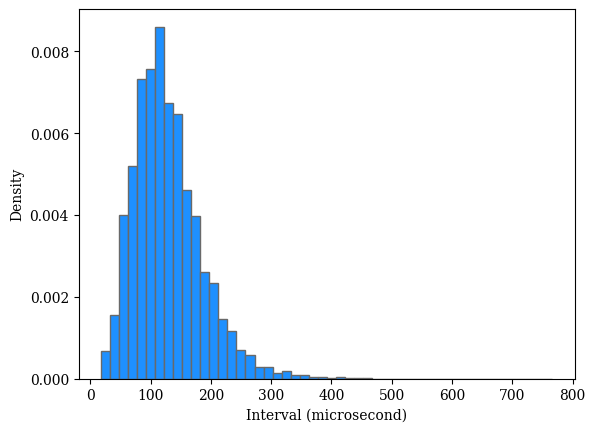

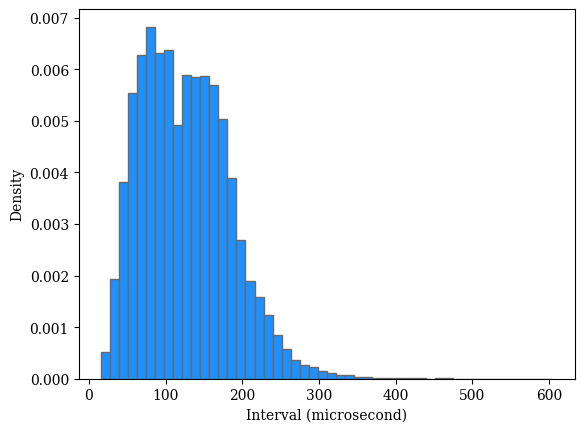

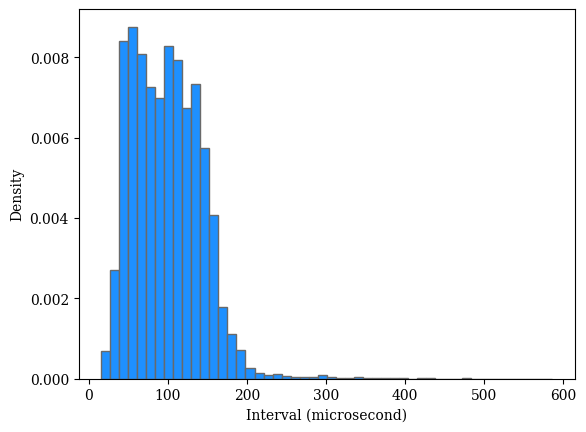

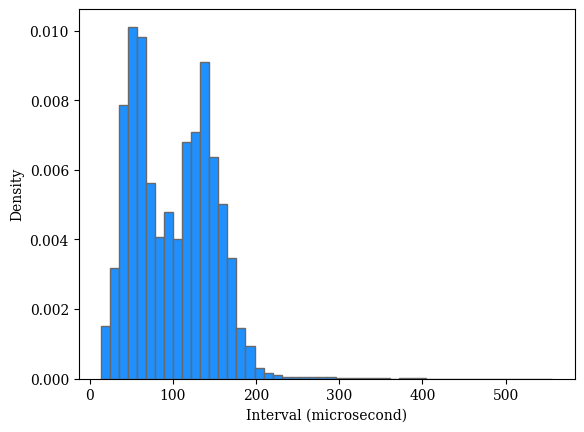

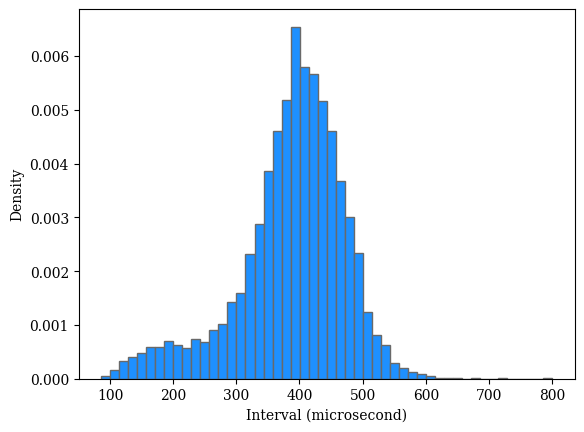

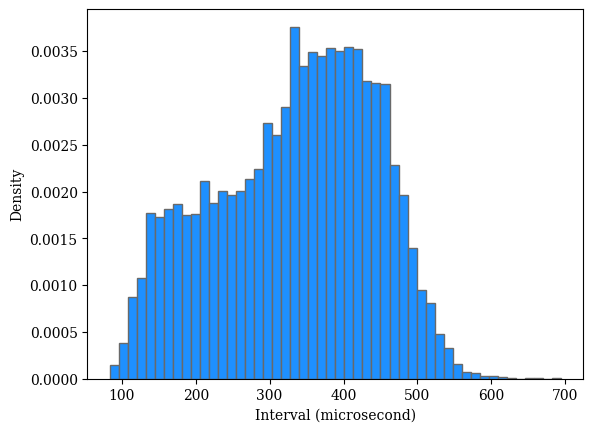

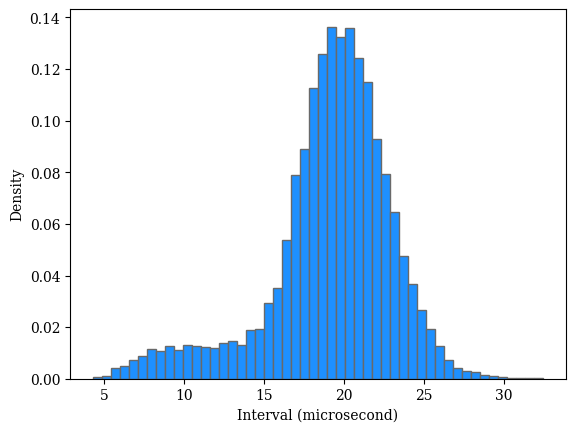

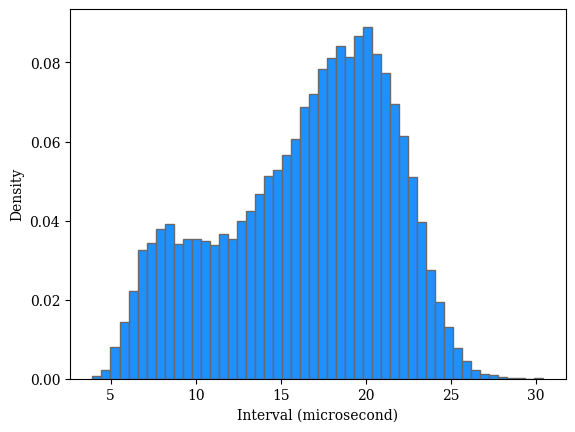

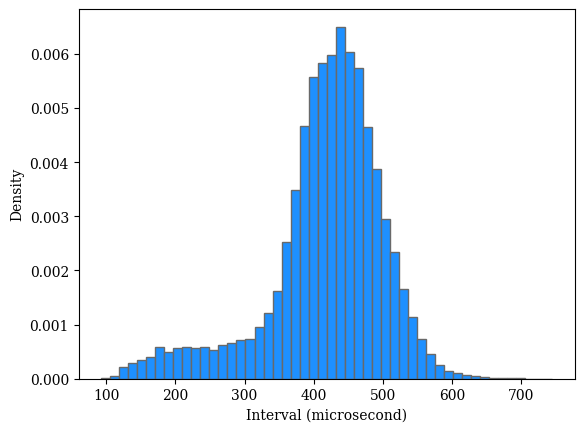

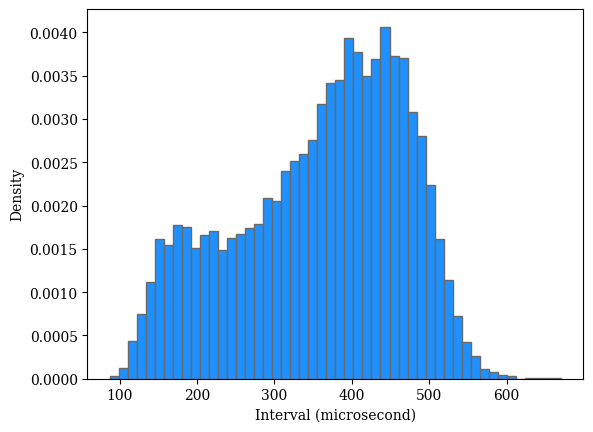

reconstructor_type='Linear', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=84.0
reference_skewness=1.1118093749325564, reconstructed_skewness=0.6949722354049416
reference_kurtosis=5.789520392606133, reconstructed_kurtosis=3.9334170360003617


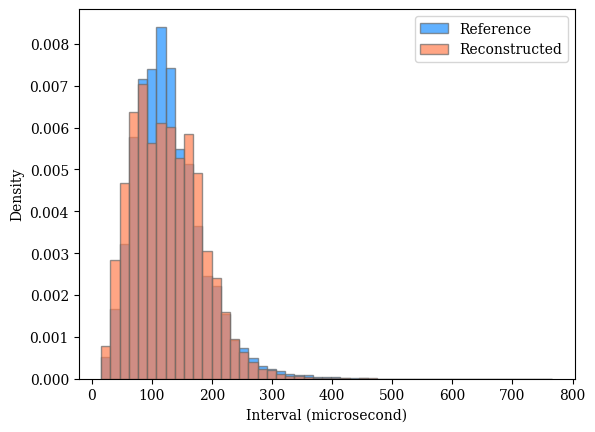

reconstructor_type='Linear', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=80.0
reference_skewness=0.9866879866785713, reconstructed_skewness=0.4969086265040999
reference_kurtosis=6.577897432072561, reconstructed_kurtosis=3.6875575543152355


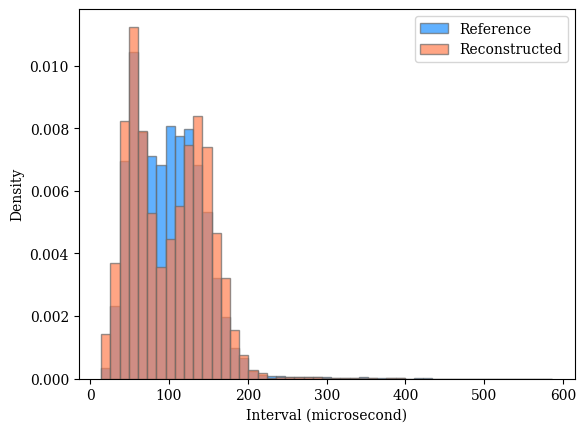

reconstructor_type='Linear', i='qt_label', j='qt_pred'
reference_iqr=94.0, reconstructed_iqr=166.0
reference_skewness=-0.8366859053918796, reconstructed_skewness=-0.26094568119500106
reference_kurtosis=4.1006046298872585, reconstructed_kurtosis=2.1989777125215166


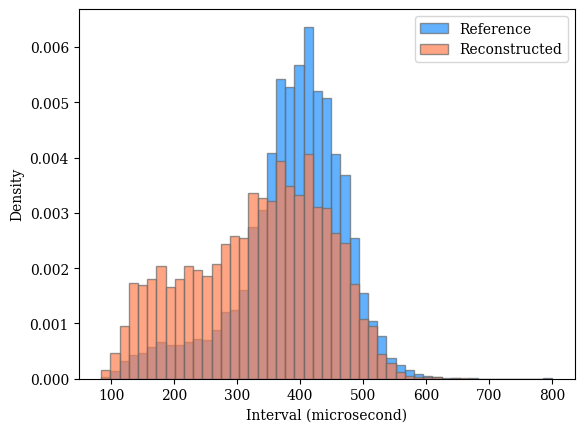

reconstructor_type='Linear', i='qtcb_label', j='qtcb_pred'
reference_iqr=3.998228983256414, reconstructed_iqr=7.396475127641981
reference_skewness=-0.9786335915471868, reconstructed_skewness=-0.41734454824827333
reference_kurtosis=4.564142547042949, reconstructed_kurtosis=2.2654354860663566


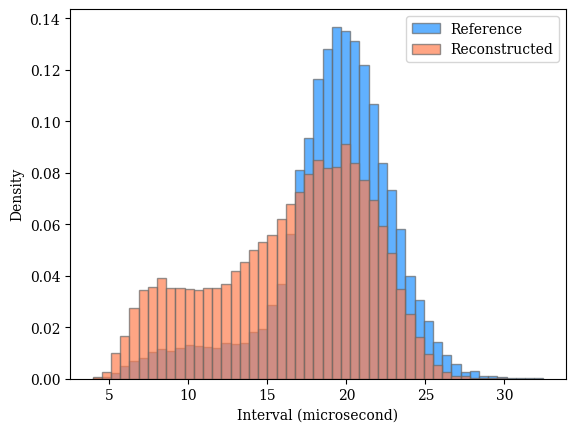

reconstructor_type='Linear', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.68082929665621, reconstructed_iqr=164.75388393505364
reference_skewness=-1.0344879415390114, reconstructed_skewness=-0.41709737941797637
reference_kurtosis=4.644220130790417, reconstructed_kurtosis=2.2386359418732953


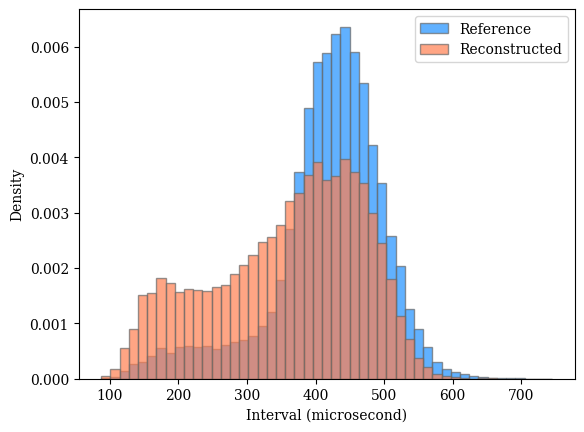


reconstructor_type='StackedCNN'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 29974
Valid locations (higher is better): 29974
Average difference (lower is better):
{'pr_diff': 0.44407067697972735, 'qrs_diff': 0.39481374453498613, 'qtcb_diff': 0.1919303661281048, 'qtcr_diff': 0.19193194421520576, 'rr_diff': 0.0007573234121156713, 'hr_diff': 0.0007575970867630718}
[9, 21, 32, 42, 47, 57, 66, 77, 84, 93, 100, 108, 119, 133, 133, 142, 153, 165, 176, 185, 192, 205, 210, 224, 226, 232, 240, 243, 248, 261, 273, 286, 297, 308, 316, 326, 327, 339, 348, 359, 364, 379, 389, 401, 413, 427, 436, 444, 457, 467, 474, 486, 495, 507, 518, 527, 537, 544, 555, 567, 576, 586, 597, 612, 623, 633, 636, 648, 660, 673, 689, 697, 705, 717, 731, 739, 750, 759, 772, 780, 788, 792, 799, 809, 820, 828, 835, 843, 859, 865, 866, 876, 883, 889, 896, 907, 917, 922, 938, 949, 957, 967, 970, 981, 994, 998, 1004, 1014, 1021, 1026, 1034, 1048, 1059, 1070, 1077, 1086, 1100, 1100, 1112, 1122, 1132, 1139, 1146, 1155, 1164, 1170, 1180, 1192, 1202, 1210, 1210, 1221, 1

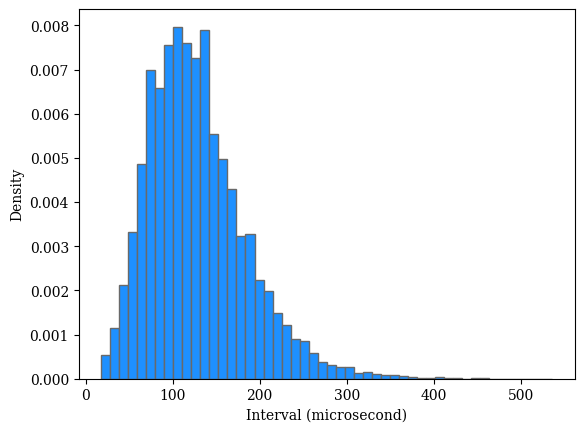

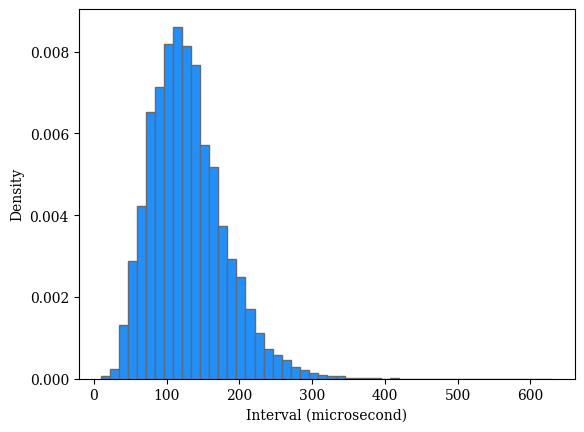

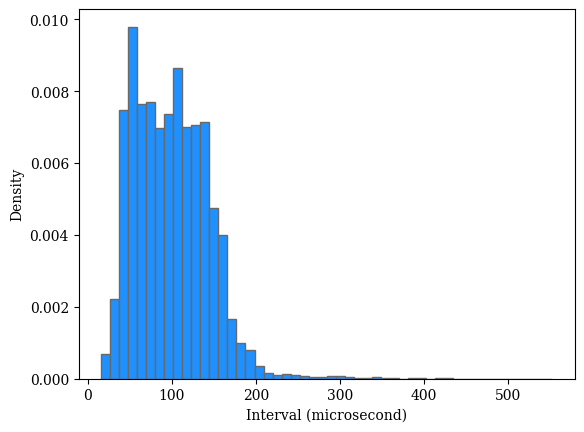

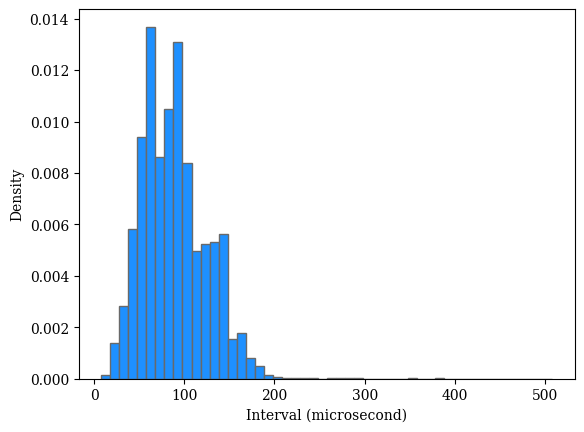

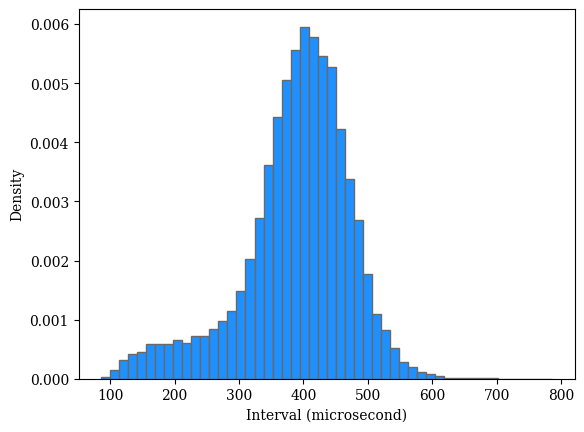

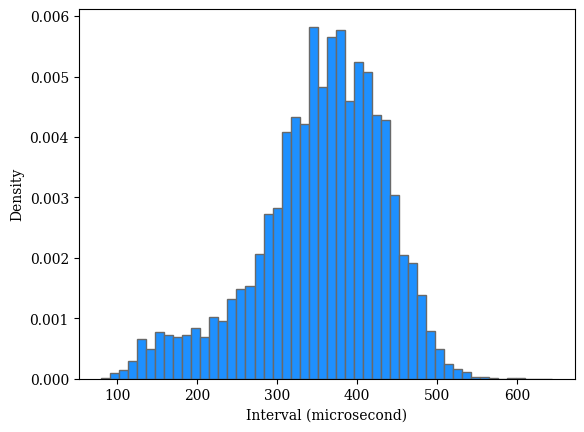

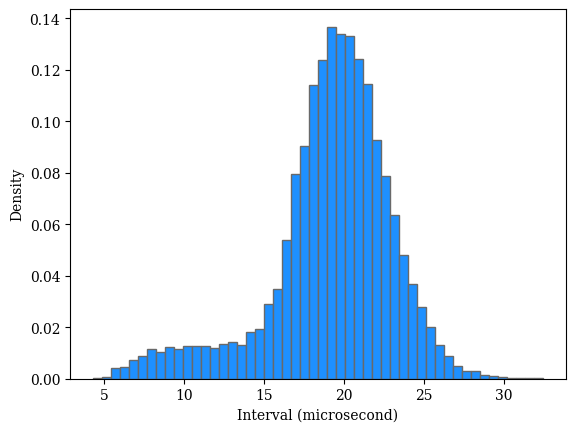

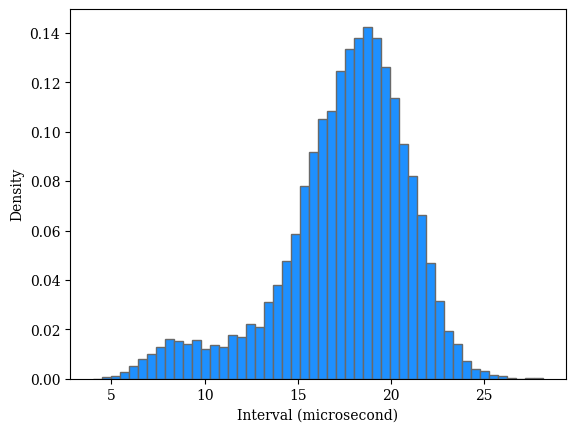

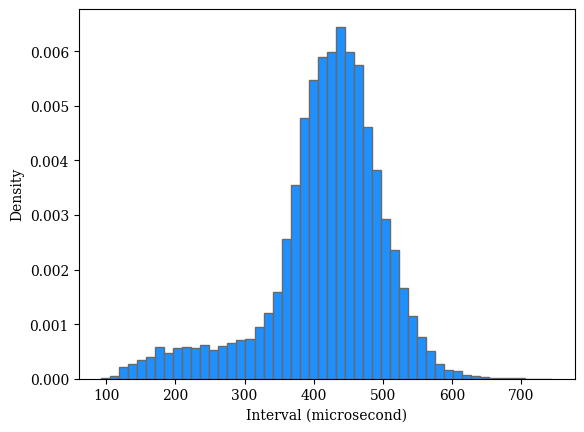

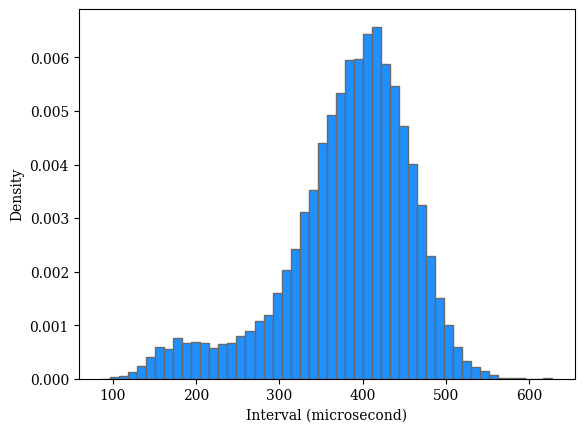

reconstructor_type='StackedCNN', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=64.0
reference_skewness=1.0312015586350542, reconstructed_skewness=0.8878300410249012
reference_kurtosis=4.978493889769813, reconstructed_kurtosis=4.832195429936651


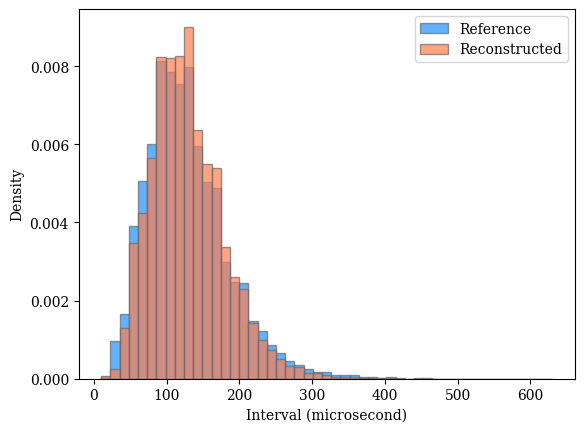

reconstructor_type='StackedCNN', i='qrs_label', j='qrs_pred'
reference_iqr=68.0, reconstructed_iqr=46.0
reference_skewness=1.0188155748830594, reconstructed_skewness=1.0131230678037924
reference_kurtosis=6.486290793434691, reconstructed_kurtosis=7.561632622241144


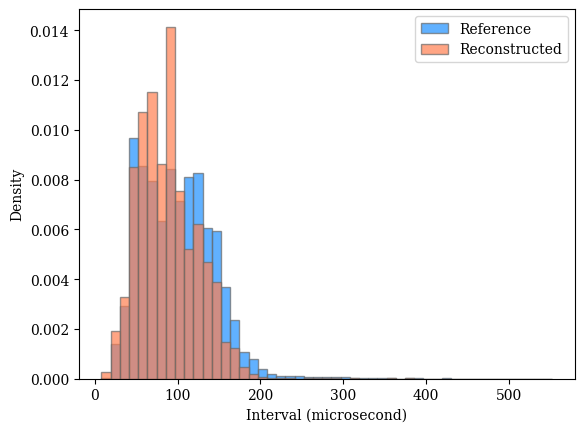

reconstructor_type='StackedCNN', i='qt_label', j='qt_pred'
reference_iqr=94.0, reconstructed_iqr=100.0
reference_skewness=-0.8311555517296342, reconstructed_skewness=-0.6813093441050123
reference_kurtosis=4.075676097933395, reconstructed_kurtosis=3.4138606669318916


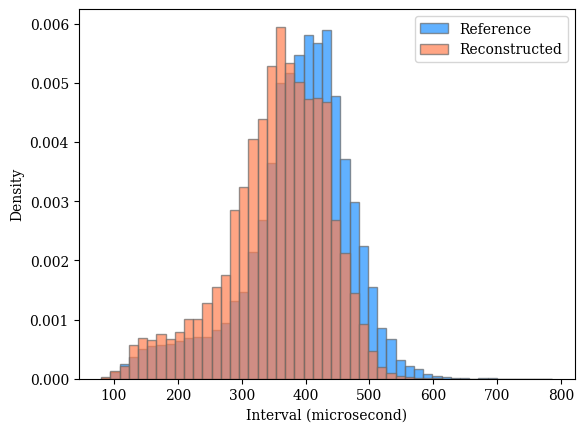

reconstructor_type='StackedCNN', i='qtcb_label', j='qtcb_pred'
reference_iqr=4.004410657740792, reconstructed_iqr=3.9851221068921063
reference_skewness=-0.9519744867278448, reconstructed_skewness=-0.9383006026467905
reference_kurtosis=4.542466833813828, reconstructed_kurtosis=4.06640708088989


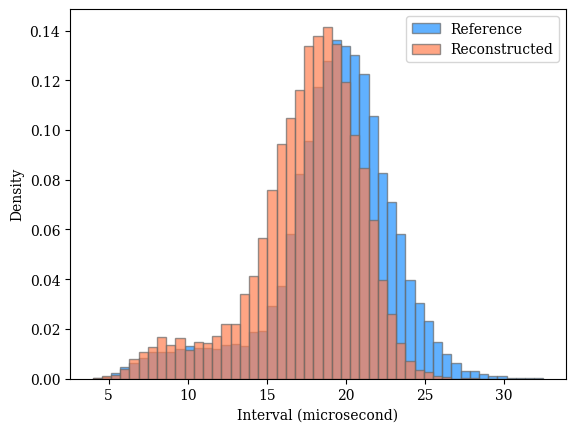

reconstructor_type='StackedCNN', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.80244556313085, reconstructed_iqr=87.9299156270896
reference_skewness=-1.0138944332366315, reconstructed_skewness=-0.9491733808350868
reference_kurtosis=4.627553320555983, reconstructed_kurtosis=4.021286017539565


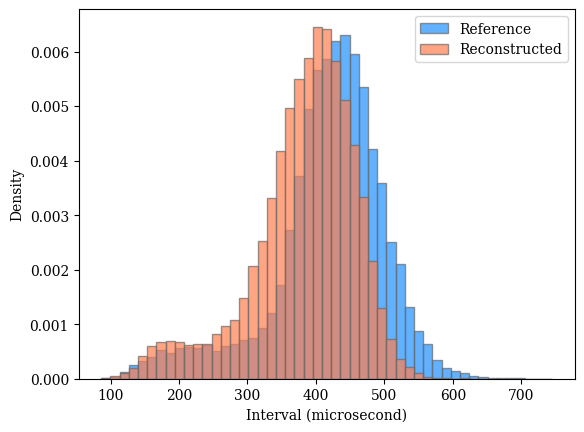


reconstructor_type='CNNLSTM'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 29339
Valid locations (higher is better): 29339
Average difference (lower is better):
{'pr_diff': 0.44024142591635673, 'qrs_diff': 0.40336436055094077, 'qtcb_diff': 0.17148449653112385, 'qtcr_diff': 0.17148403367588477, 'rr_diff': 0.0007511235082353489, 'hr_diff': 0.0007512139730466}
[9, 20, 20, 30, 35, 45, 54, 65, 71, 80, 87, 95, 105, 115, 115, 124, 135, 147, 158, 167, 174, 187, 188, 202, 203, 209, 217, 217, 221, 234, 246, 253, 264, 275, 282, 292, 293, 305, 314, 325, 330, 345, 355, 366, 378, 392, 401, 409, 422, 432, 439, 451, 460, 471, 482, 491, 501, 508, 519, 531, 540, 550, 561, 576, 587, 597, 598, 610, 622, 635, 651, 659, 667, 679, 693, 701, 712, 721, 734, 742, 750, 754, 761, 771, 782, 790, 798, 808, 822, 828, 829, 839, 846, 852, 859, 869, 880, 884, 900, 911, 919, 929, 932, 943, 956, 959, 965, 975, 982, 986, 994, 1003, 1014, 1025, 1033, 1042, 1056, 1059, 1071, 1081, 1091, 1097, 1104, 1113, 1123, 1129, 1139, 1150, 1160, 1168, 1168, 1179, 1188, 1194

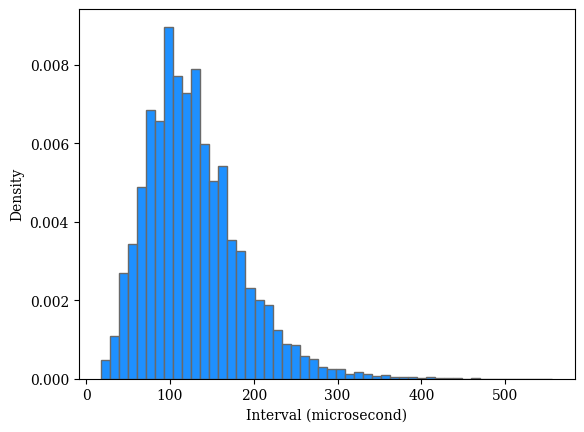

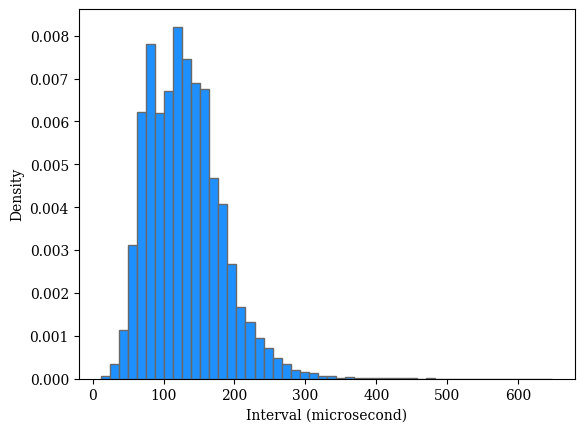

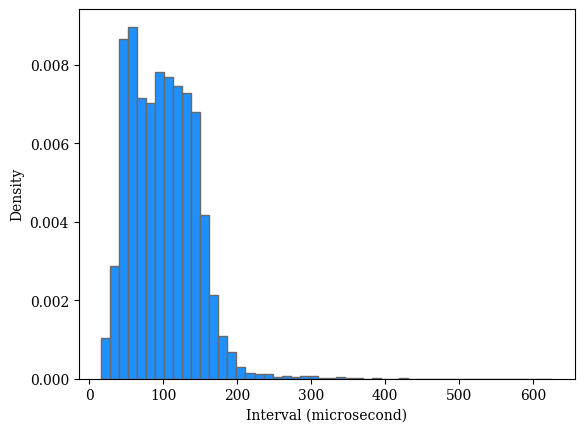

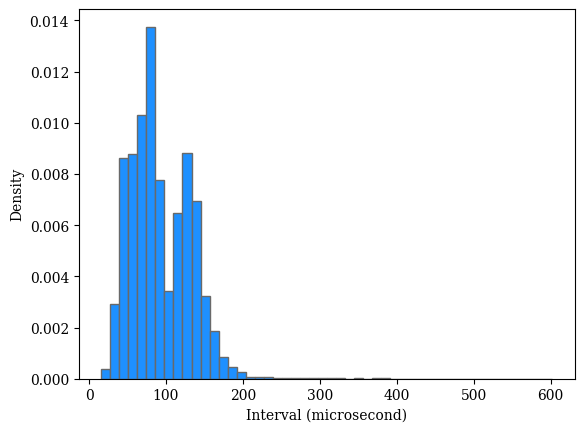

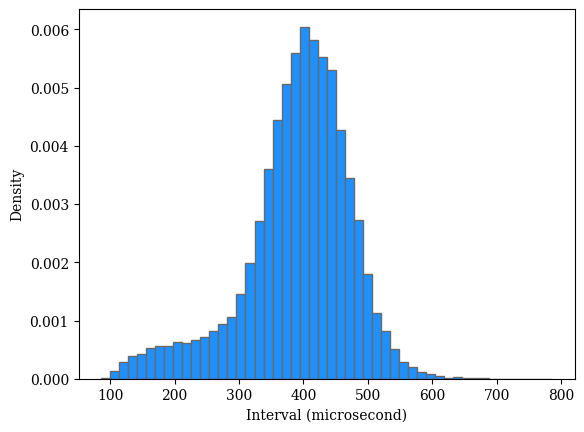

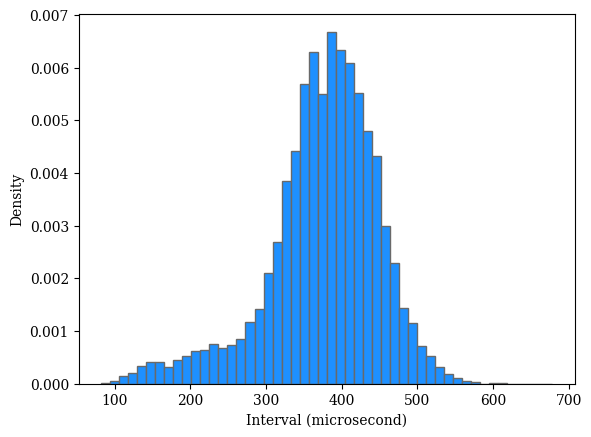

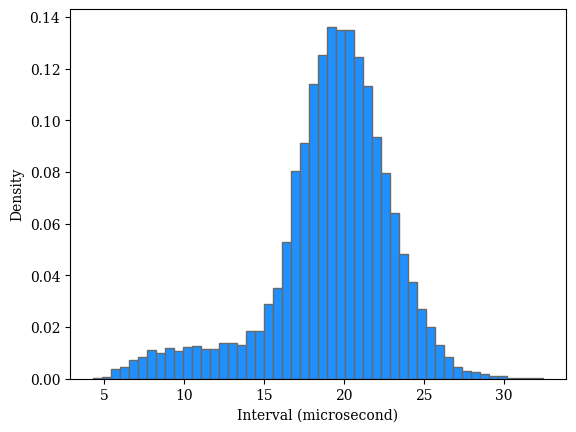

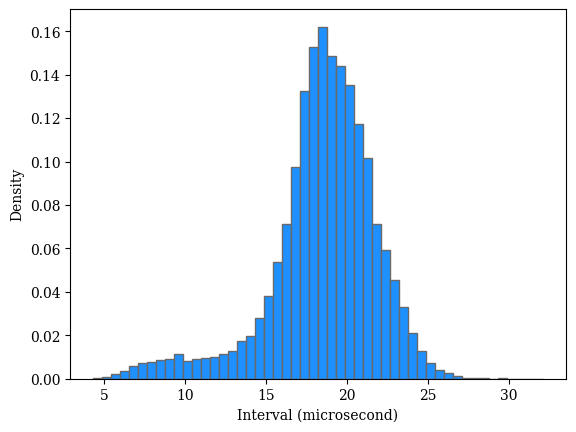

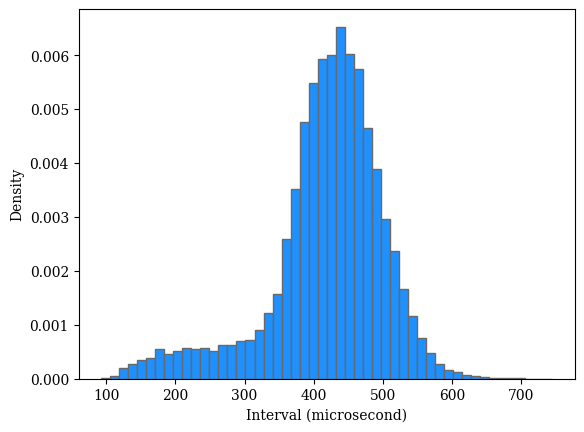

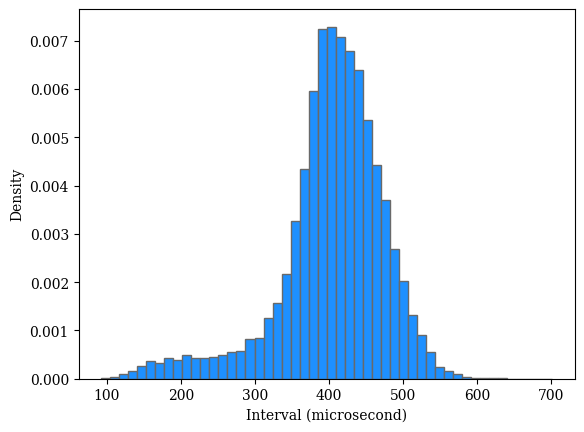

reconstructor_type='CNNLSTM', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=70.0
reference_skewness=1.0424723051286535, reconstructed_skewness=0.9293990368253153
reference_kurtosis=5.041594460412965, reconstructed_kurtosis=5.19819766942329


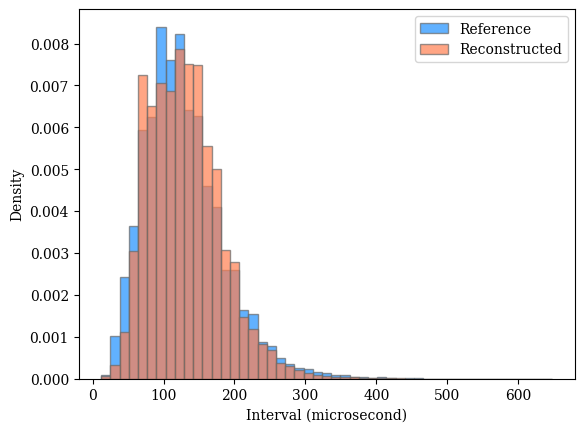

reconstructor_type='CNNLSTM', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=60.0
reference_skewness=0.9751926016103176, reconstructed_skewness=0.9676651940465627
reference_kurtosis=6.484125400765361, reconstructed_kurtosis=6.675462143286551


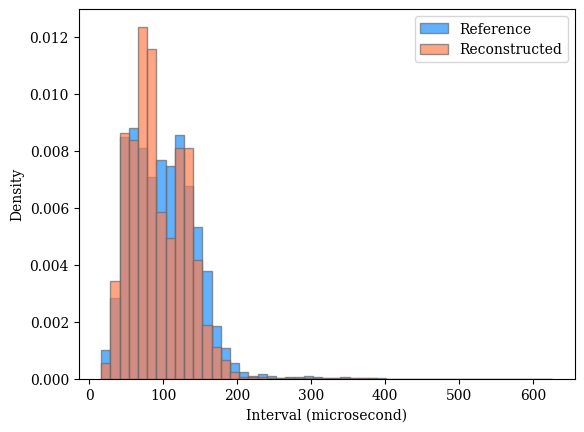

reconstructor_type='CNNLSTM', i='qt_label', j='qt_pred'
reference_iqr=92.0, reconstructed_iqr=82.0
reference_skewness=-0.8325649029026725, reconstructed_skewness=-0.8509461050818296
reference_kurtosis=4.153270429704634, reconstructed_kurtosis=4.403933554841579


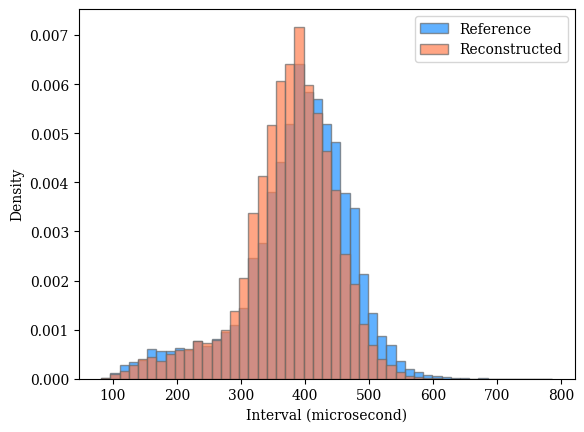

reconstructor_type='CNNLSTM', i='qtcb_label', j='qtcb_pred'
reference_iqr=3.9666704510621287, reconstructed_iqr=3.4372336870454987
reference_skewness=-0.9573799297420549, reconstructed_skewness=-1.0463959920669008
reference_kurtosis=4.604933011232706, reconstructed_kurtosis=5.137740868505988


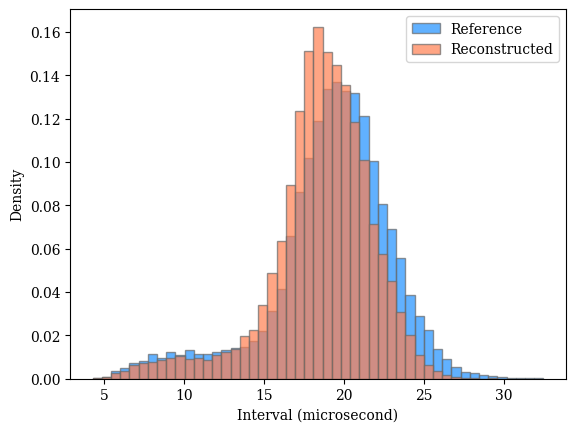

reconstructor_type='CNNLSTM', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.14711718649494, reconstructed_iqr=73.56103497960964
reference_skewness=-1.0199089909654184, reconstructed_skewness=-1.1040514404275161
reference_kurtosis=4.697199077582589, reconstructed_kurtosis=5.22542558584656


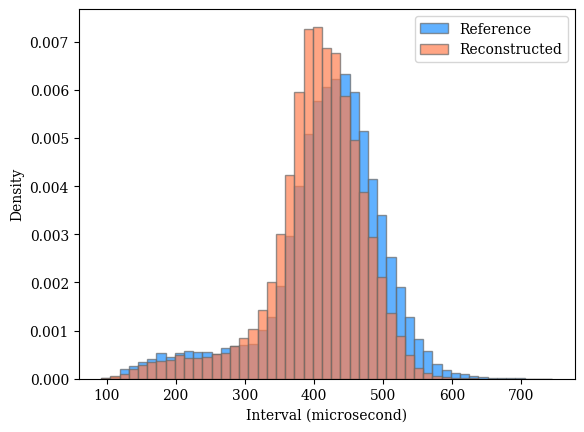


reconstructor_type='LSTM'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 28430
Valid locations (higher is better): 28430
Average difference (lower is better):
{'pr_diff': 0.4360488278844762, 'qrs_diff': 0.3517921048995748, 'qtcb_diff': 0.16958887320670085, 'qtcr_diff': 0.16959045783339782, 'rr_diff': 0.0005912260699032371, 'hr_diff': 0.0005918702531636373}
[9, 21, 32, 42, 46, 55, 64, 75, 76, 82, 89, 97, 108, 121, 121, 126, 137, 148, 155, 163, 170, 183, 184, 198, 200, 206, 214, 214, 219, 232, 242, 254, 265, 276, 282, 292, 293, 305, 314, 325, 328, 343, 353, 364, 376, 390, 398, 406, 419, 429, 436, 447, 456, 468, 478, 487, 497, 504, 515, 527, 535, 545, 556, 571, 582, 592, 593, 605, 617, 628, 644, 652, 660, 672, 686, 694, 703, 704, 717, 725, 733, 737, 745, 755, 766, 774, 781, 791, 807, 813, 814, 824, 831, 837, 844, 854, 866, 869, 885, 896, 904, 913, 916, 927, 939, 943, 949, 958, 965, 967, 975, 988, 999, 1010, 1017, 1026, 1040, 1041, 1053, 1063, 1073, 1079, 1086, 1095, 1104, 1107, 1117, 1129, 1139, 1147, 1147, 1158, 1165, 1171,

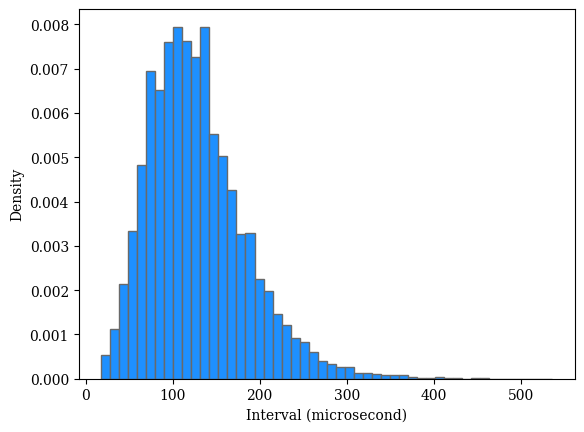

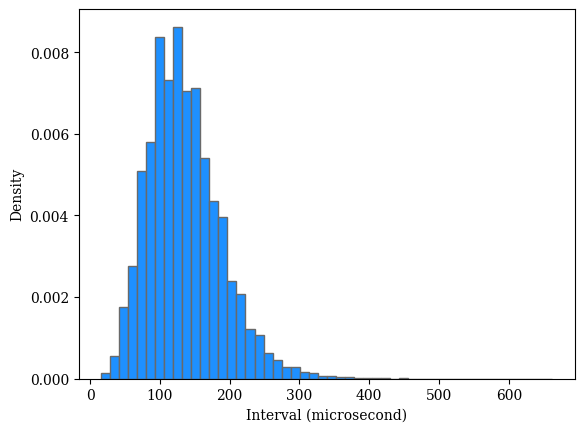

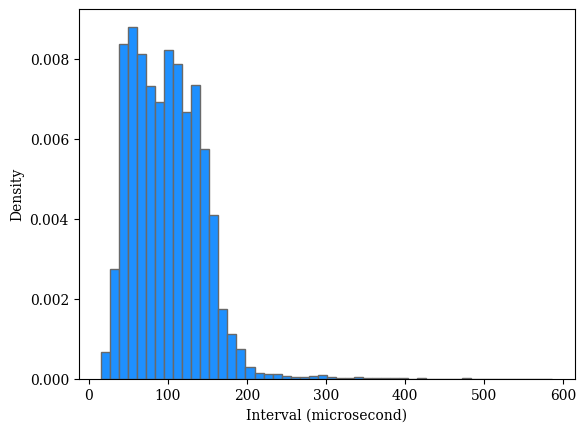

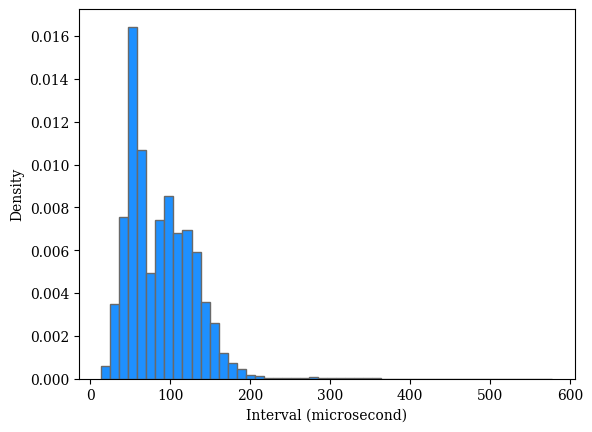

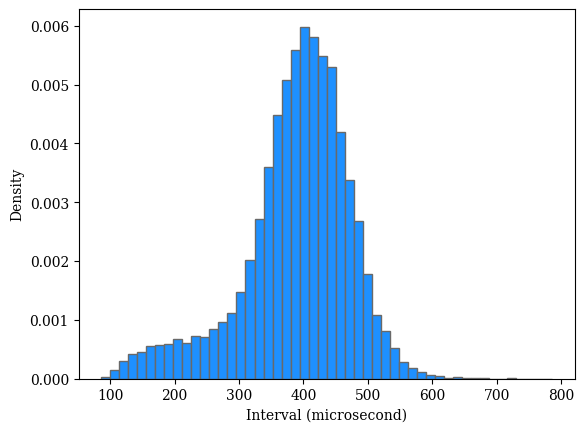

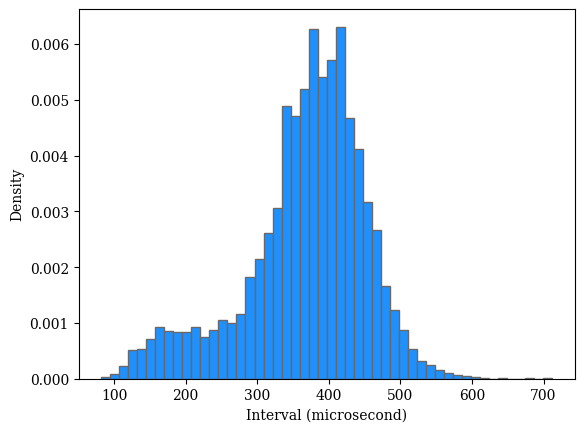

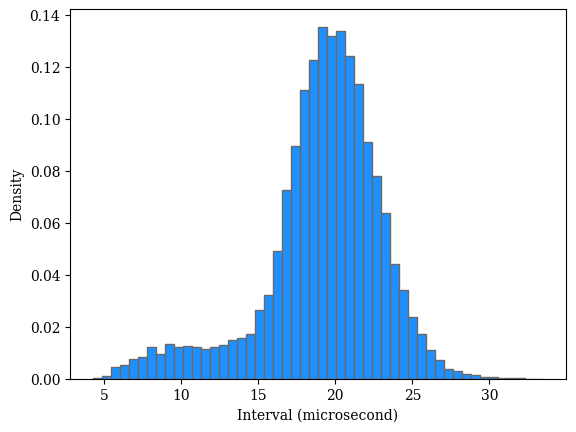

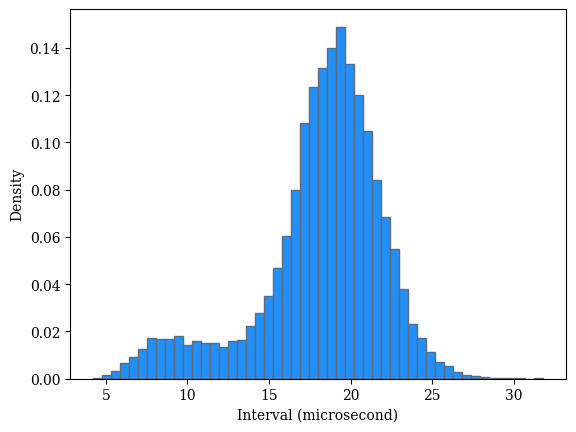

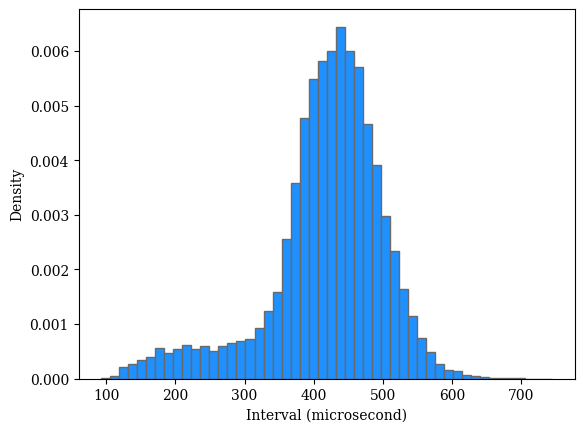

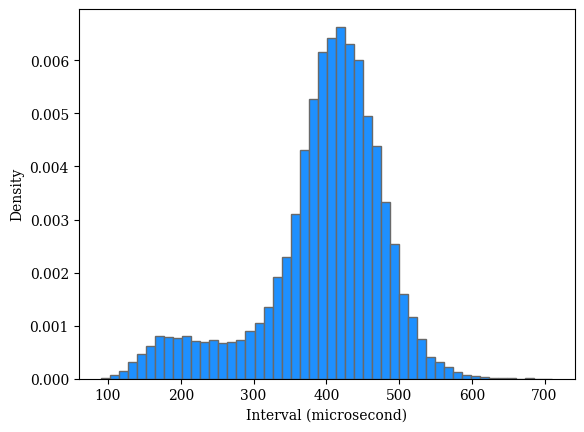

reconstructor_type='LSTM', i='pr_label', j='pr_pred'
reference_iqr=68.0, reconstructed_iqr=68.0
reference_skewness=1.020171849760449, reconstructed_skewness=0.9572195365389893
reference_kurtosis=4.914106345969537, reconstructed_kurtosis=5.518929802752223


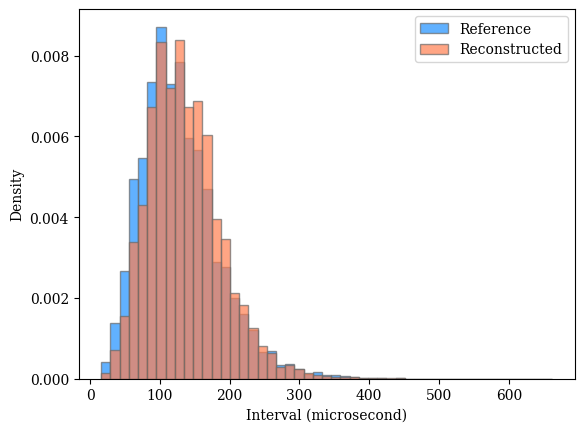

reconstructor_type='LSTM', i='qrs_label', j='qrs_pred'
reference_iqr=68.0, reconstructed_iqr=62.0
reference_skewness=1.0878196000319673, reconstructed_skewness=1.2413656440084295
reference_kurtosis=7.285173451619274, reconstructed_kurtosis=7.619834713257813


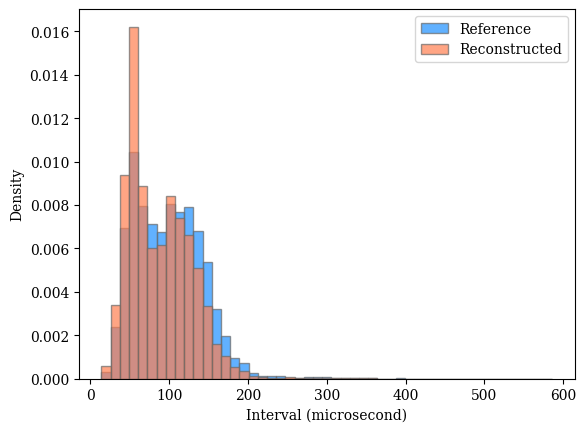

reconstructor_type='LSTM', i='qt_label', j='qt_pred'
reference_iqr=94.0, reconstructed_iqr=96.0
reference_skewness=-0.8329288477320468, reconstructed_skewness=-0.7707275984435547
reference_kurtosis=4.109768577488092, reconstructed_kurtosis=3.693048047654718


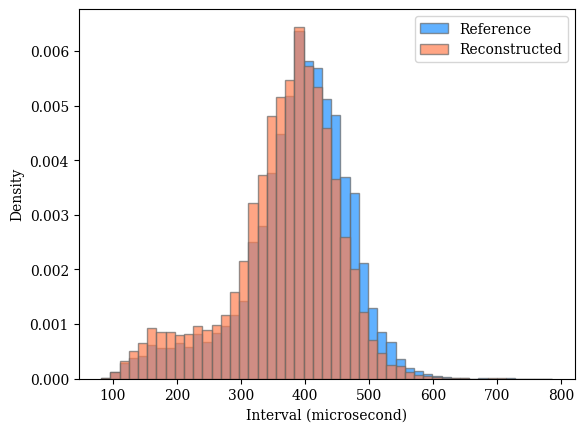

reconstructor_type='LSTM', i='qtcb_label', j='qtcb_pred'
reference_iqr=4.016249624358434, reconstructed_iqr=3.8989447756526516
reference_skewness=-0.9604803930653661, reconstructed_skewness=-1.0016899773792765
reference_kurtosis=4.569494789432428, reconstructed_kurtosis=4.19318309873263


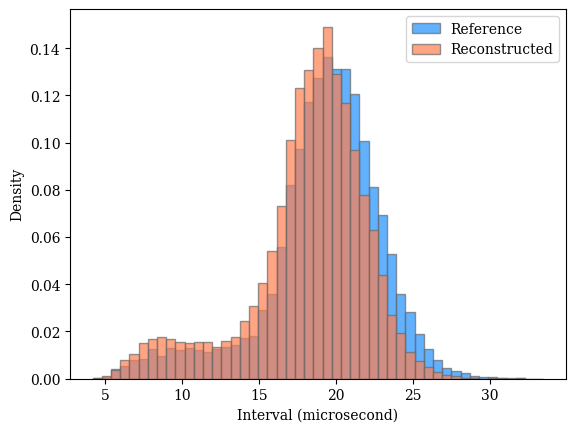

reconstructor_type='LSTM', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.91221952029684, reconstructed_iqr=84.30276101900932
reference_skewness=-1.0226412054076108, reconstructed_skewness=-1.0306084610664727
reference_kurtosis=4.659797843682679, reconstructed_kurtosis=4.214437110286707


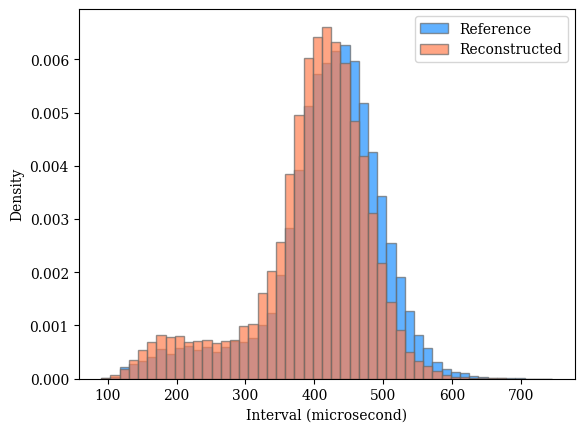


reconstructor_type='UNet'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 29735
Valid locations (higher is better): 29735
Average difference (lower is better):
{'pr_diff': 0.5668044273804929, 'qrs_diff': 0.39318855995942337, 'qtcb_diff': 0.19281935237265005, 'qtcr_diff': 0.19281757258141702, 'rr_diff': 0.0007809981507736557, 'hr_diff': 0.0007808432000502428}
[9, 21, 32, 42, 47, 58, 67, 78, 85, 94, 101, 109, 120, 130, 130, 139, 150, 162, 173, 182, 189, 202, 206, 220, 222, 228, 236, 237, 242, 255, 267, 280, 291, 302, 308, 318, 318, 330, 339, 350, 355, 370, 380, 391, 403, 417, 426, 434, 448, 458, 465, 477, 487, 499, 506, 515, 525, 532, 543, 555, 564, 574, 585, 600, 611, 621, 624, 636, 648, 661, 676, 684, 692, 704, 718, 726, 737, 746, 759, 767, 775, 779, 787, 797, 808, 815, 822, 832, 847, 853, 854, 864, 871, 877, 884, 895, 907, 912, 928, 939, 947, 957, 960, 971, 983, 987, 993, 1002, 1009, 1013, 1021, 1033, 1044, 1055, 1063, 1071, 1085, 1090, 1102, 1112, 1122, 1129, 1136, 1145, 1155, 1161, 1171, 1182, 1192, 1200, 1200, 1211, 12

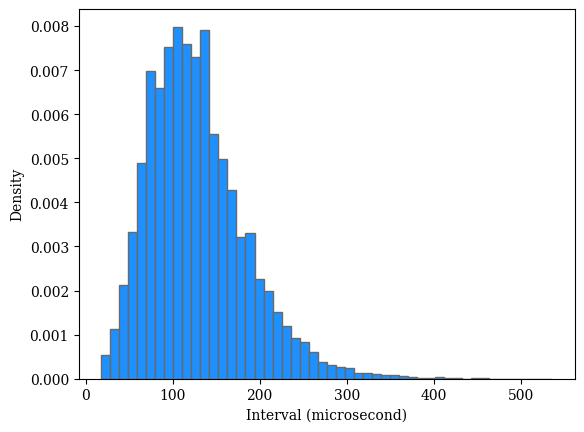

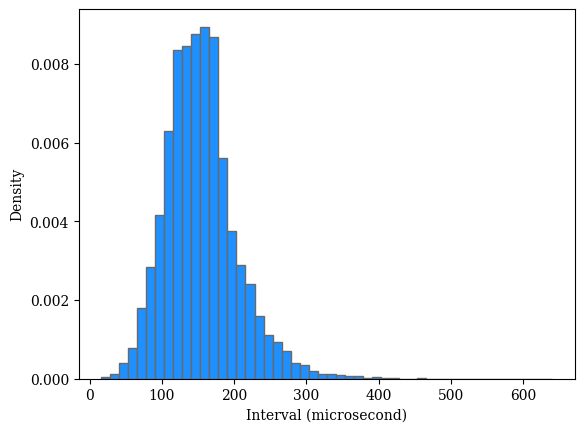

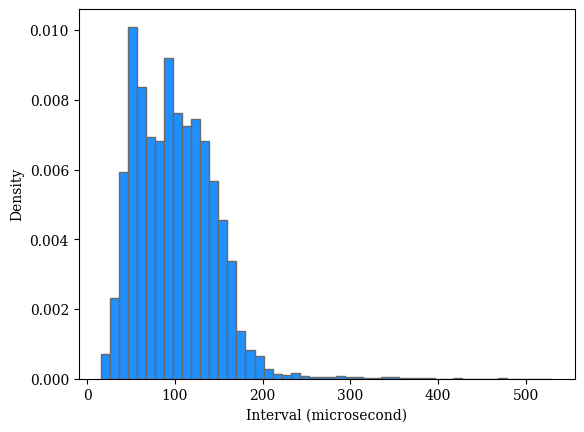

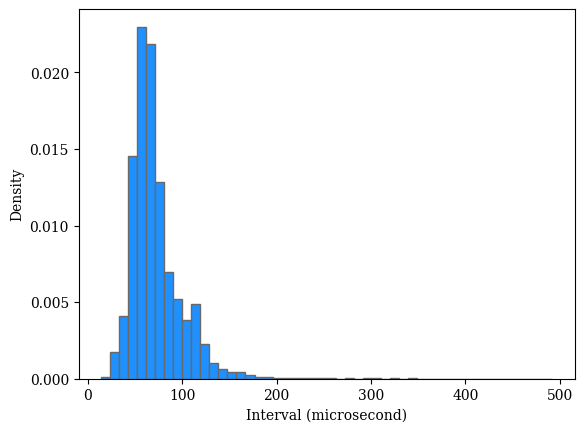

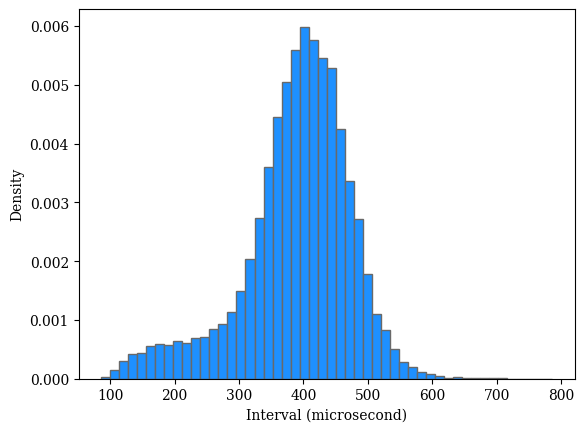

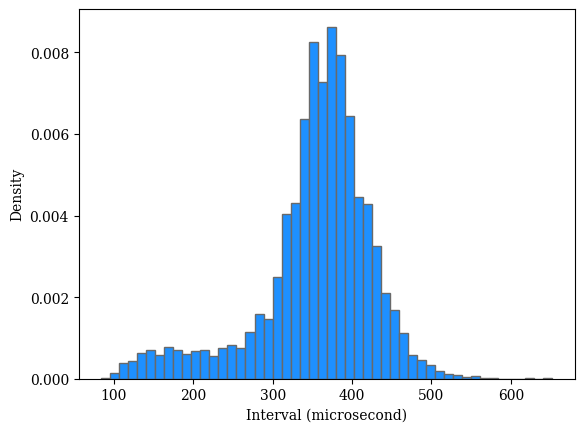

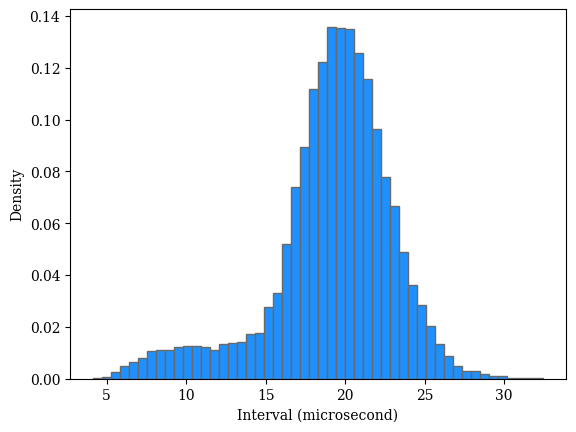

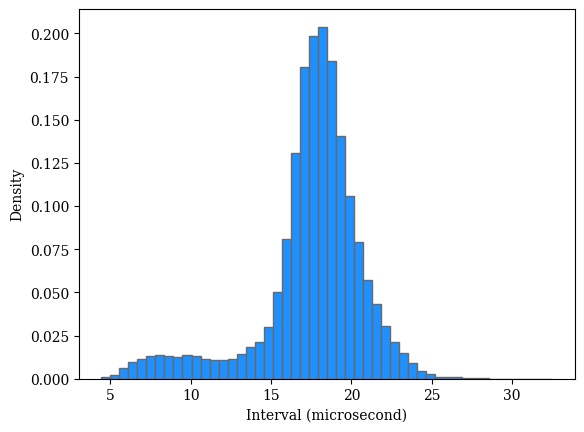

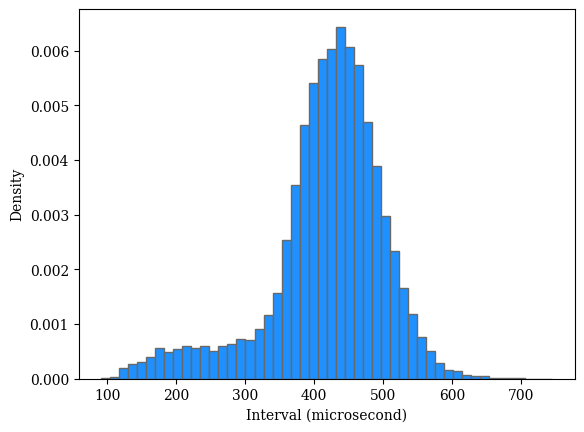

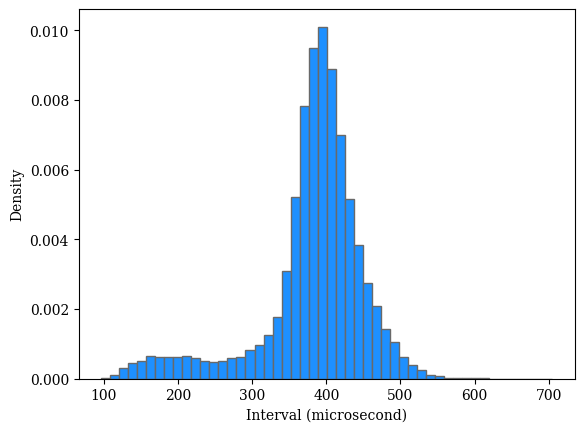

reconstructor_type='UNet', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=58.0
reference_skewness=1.0136595975813298, reconstructed_skewness=0.9329792980304673
reference_kurtosis=4.903482609239537, reconstructed_kurtosis=5.629811949580206


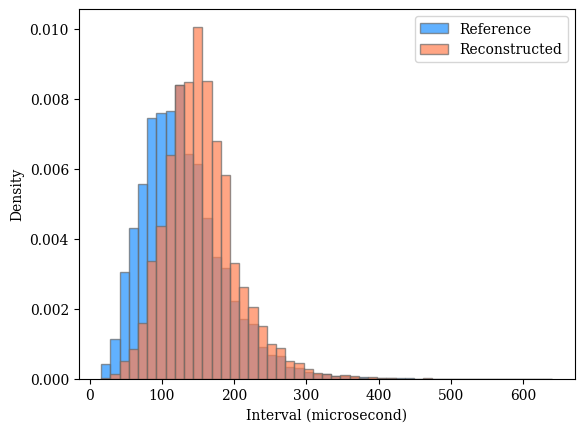

reconstructor_type='UNet', i='qrs_label', j='qrs_pred'
reference_iqr=68.0, reconstructed_iqr=26.0
reference_skewness=1.0049839085319157, reconstructed_skewness=3.2378943658770027
reference_kurtosis=6.464364988252984, reconstructed_kurtosis=28.01148480759503


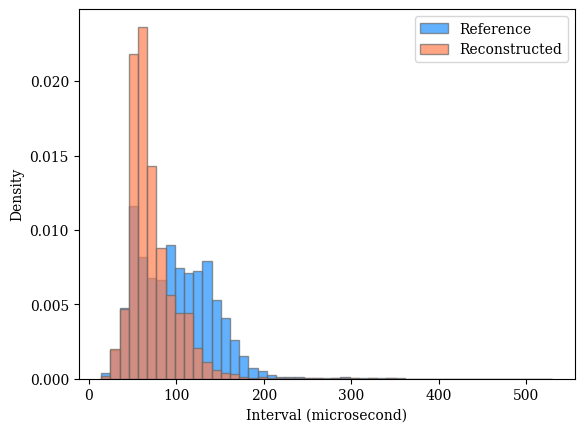

reconstructor_type='UNet', i='qt_label', j='qt_pred'
reference_iqr=94.0, reconstructed_iqr=68.0
reference_skewness=-0.8271260635413984, reconstructed_skewness=-1.064171507387829
reference_kurtosis=4.120672893649185, reconstructed_kurtosis=4.759406697241645


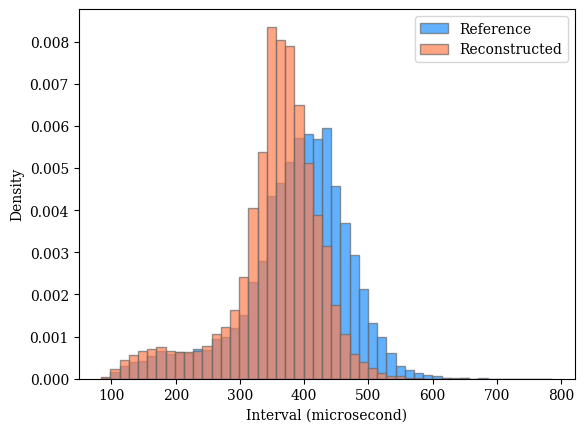

reconstructor_type='UNet', i='qtcb_label', j='qtcb_pred'
reference_iqr=3.989139320163382, reconstructed_iqr=2.7226808661461988
reference_skewness=-0.9540301063106882, reconstructed_skewness=-1.2962528949562484
reference_kurtosis=4.565465881144252, reconstructed_kurtosis=5.613842090628255


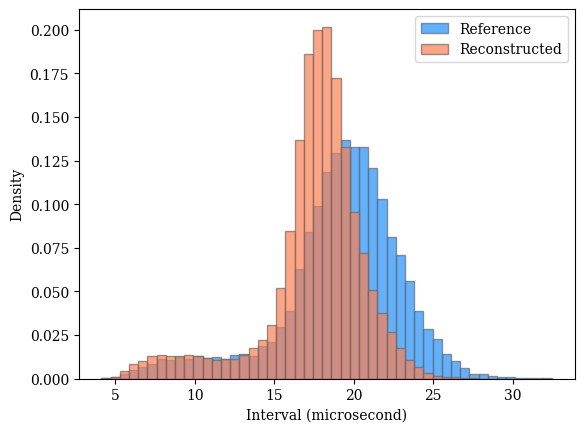

reconstructor_type='UNet', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.59052286447462, reconstructed_iqr=56.450622318534045
reference_skewness=-1.0148373308797183, reconstructed_skewness=-1.3575066640668545
reference_kurtosis=4.654067148383876, reconstructed_kurtosis=5.71398955590128


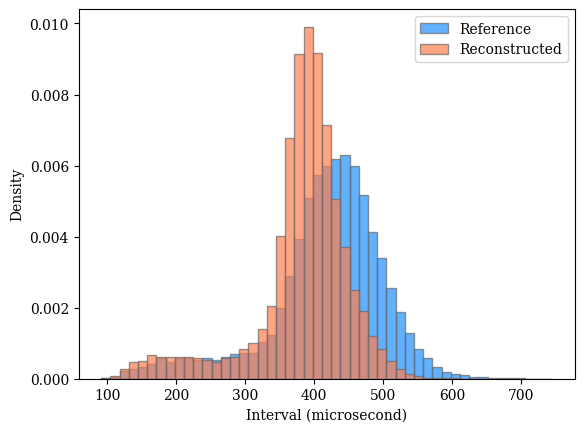

2023-07-24 20:04:22.129108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 20:04:22.158157: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


reconstructor_type='Fastformer'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 29577
Valid locations (higher is better): 29577
Average difference (lower is better):
{'pr_diff': 0.558234159035919, 'qrs_diff': 0.4720661298646135, 'qtcb_diff': 0.2497505972809887, 'qtcr_diff': 0.24975000578047032, 'rr_diff': 0.0009928402617494995, 'hr_diff': 0.0009937440545792786}
[9, 21, 31, 41, 46, 57, 66, 77, 81, 90, 97, 105, 116, 129, 129, 138, 149, 161, 172, 181, 188, 201, 203, 217, 218, 224, 232, 234, 240, 253, 265, 278, 289, 300, 307, 317, 318, 329, 338, 350, 355, 370, 378, 389, 401, 415, 424, 432, 445, 455, 462, 474, 483, 495, 506, 515, 525, 532, 543, 555, 564, 574, 585, 598, 609, 619, 622, 634, 646, 659, 675, 683, 691, 704, 718, 726, 737, 746, 759, 767, 775, 779, 787, 797, 808, 813, 820, 829, 845, 851, 852, 862, 869, 875, 882, 893, 905, 907, 923, 934, 942, 952, 955, 966, 979, 983, 989, 999, 1006, 1007, 1015, 1023, 1034, 1045, 1053, 1062, 1076, 1087, 1099, 1109, 1119, 1126, 1133, 1142, 1151, 1156, 1166, 1178, 1188, 1196, 1196, 1207, 1216, 1

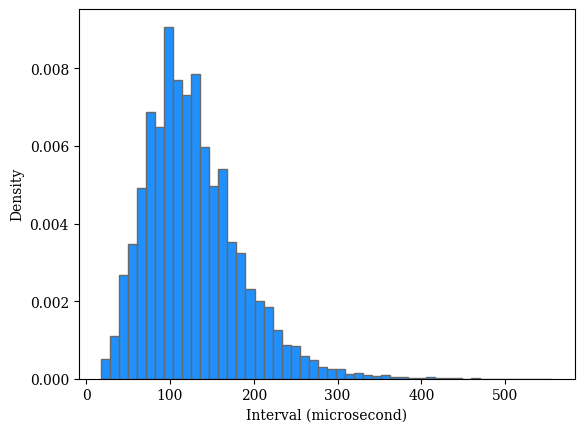

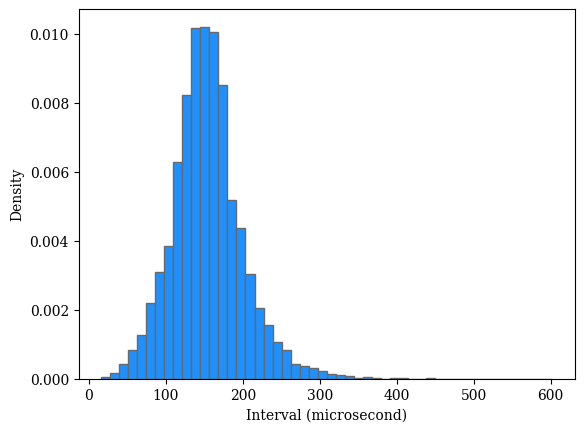

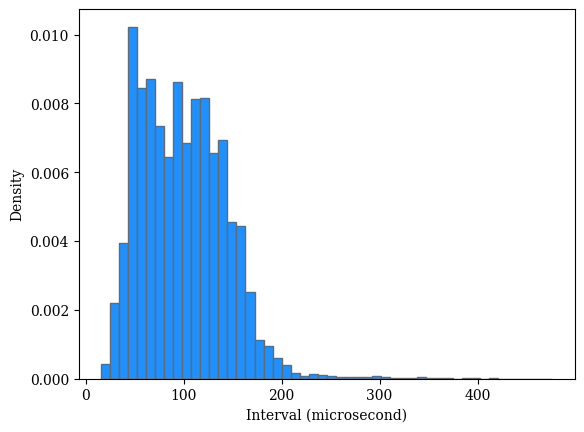

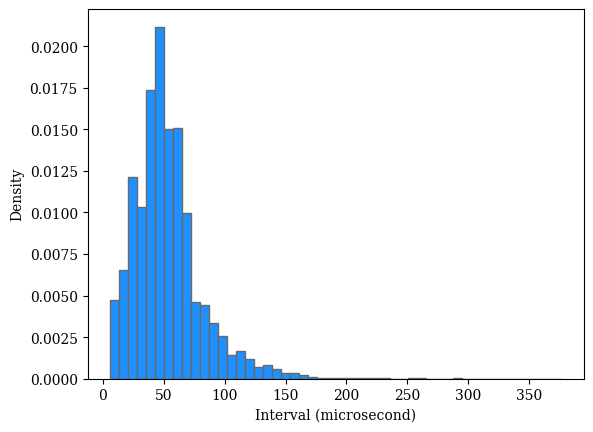

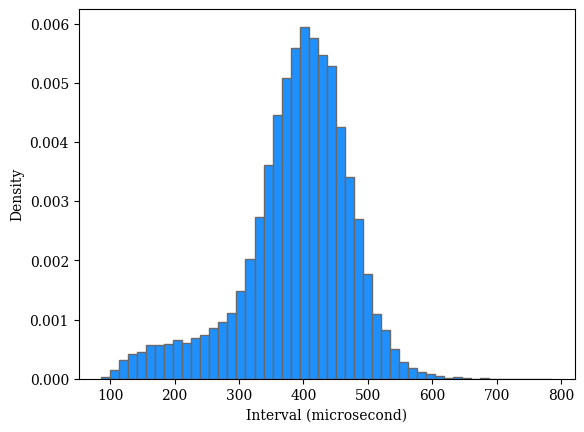

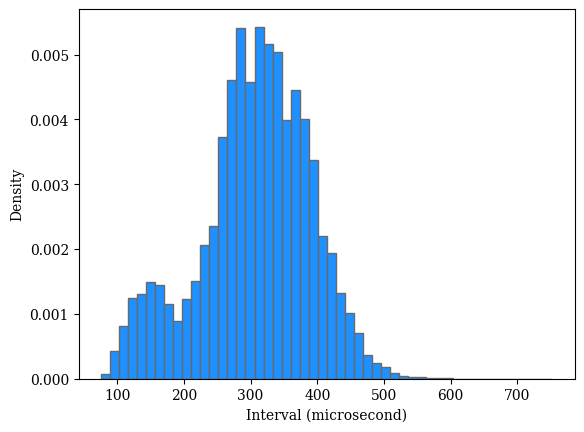

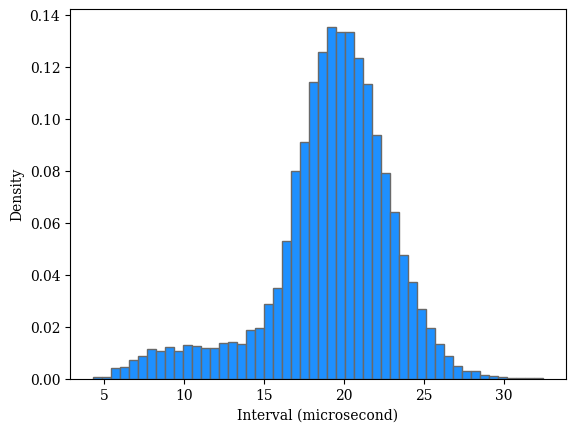

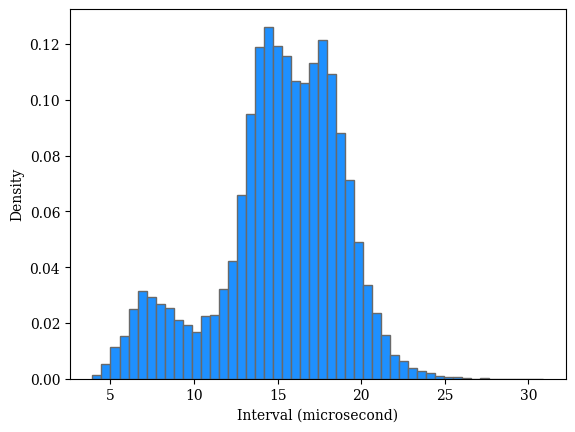

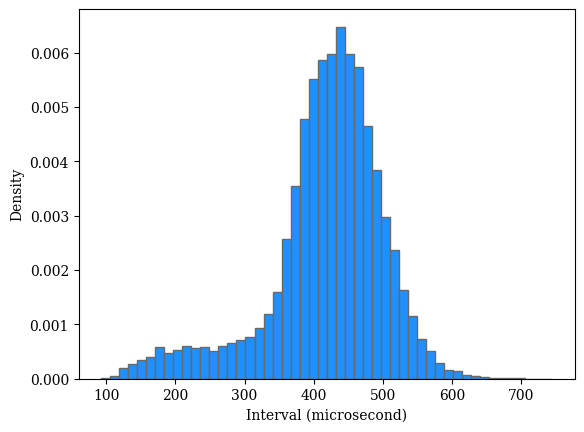

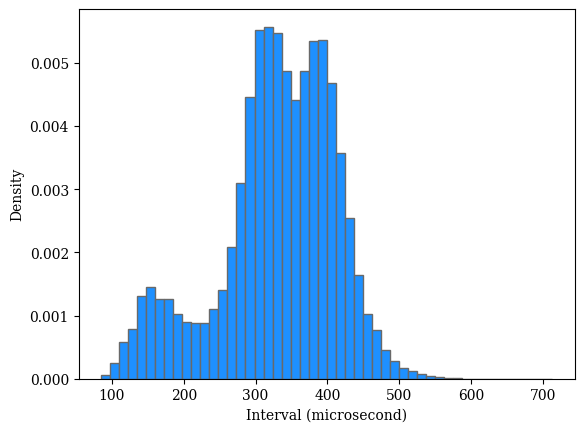

reconstructor_type='Fastformer', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=52.0
reference_skewness=1.0416420867136982, reconstructed_skewness=0.686723332876079
reference_kurtosis=5.088106389366843, reconstructed_kurtosis=5.309753287203153


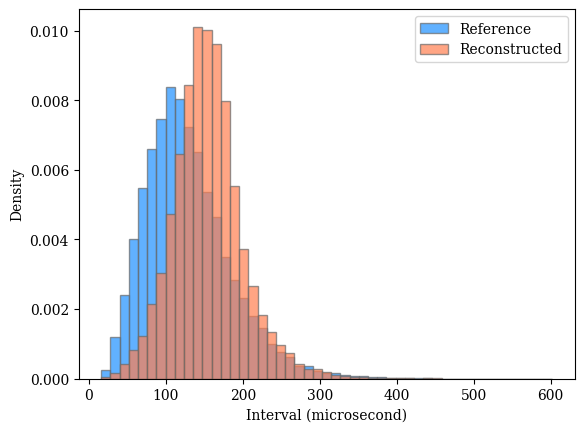

reconstructor_type='Fastformer', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=28.0
reference_skewness=0.8824792665583239, reconstructed_skewness=1.7912561231637327
reference_kurtosis=5.495939229610958, reconstructed_kurtosis=10.830457471802413


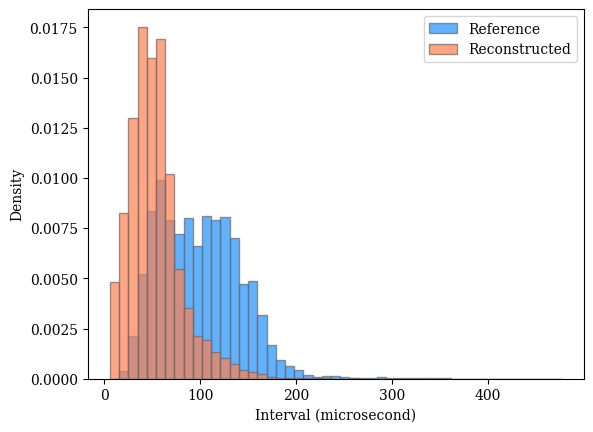

reconstructor_type='Fastformer', i='qt_label', j='qt_pred'
reference_iqr=94.0, reconstructed_iqr=102.0
reference_skewness=-0.8357494028140249, reconstructed_skewness=-0.36679186459540136
reference_kurtosis=4.099655169016803, reconstructed_kurtosis=2.9873754435746167


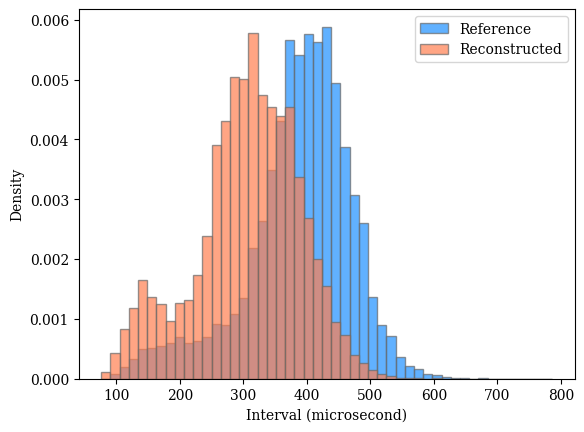

reconstructor_type='Fastformer', i='qtcb_label', j='qtcb_pred'
reference_iqr=4.004316318112611, reconstructed_iqr=4.338793689337358
reference_skewness=-0.9542032406728163, reconstructed_skewness=-0.6552352975025951
reference_kurtosis=4.552810717136754, reconstructed_kurtosis=3.254229148734057


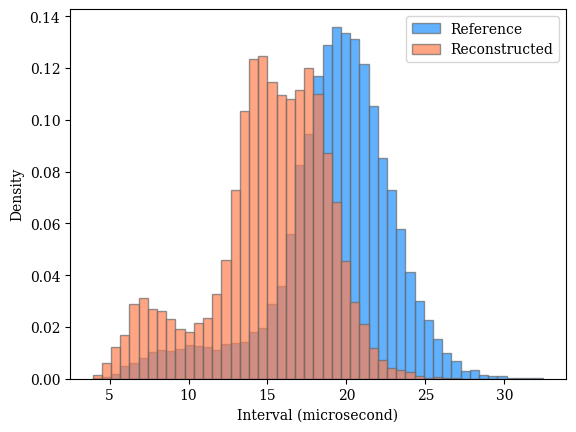

reconstructor_type='Fastformer', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.70201514626717, reconstructed_iqr=97.55934705588896
reference_skewness=-1.017327267324245, reconstructed_skewness=-0.636965463459508
reference_kurtosis=4.641322577579297, reconstructed_kurtosis=3.2048611359942507


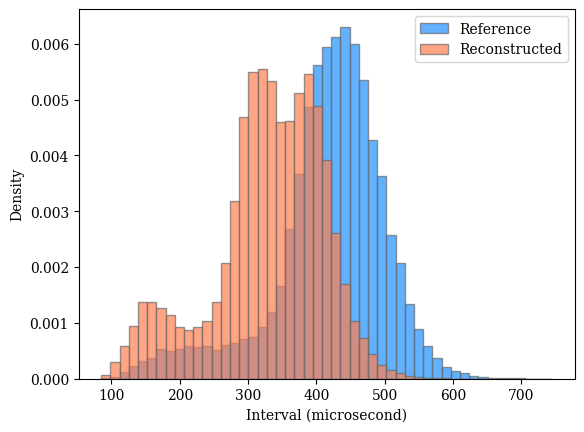


reconstructor_type='FastformerPlus'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 29785
Valid locations (higher is better): 29785
Average difference (lower is better):
{'pr_diff': 0.5083636505297768, 'qrs_diff': 0.3861270473226535, 'qtcb_diff': 0.20942000859133145, 'qtcr_diff': 0.20941933534546223, 'rr_diff': 0.0008177472168689684, 'hr_diff': 0.0008174795646090822}
[9, 21, 32, 42, 47, 57, 66, 77, 84, 93, 100, 108, 119, 132, 132, 141, 152, 164, 175, 184, 191, 204, 205, 219, 221, 227, 235, 237, 243, 256, 268, 281, 292, 303, 310, 320, 324, 336, 345, 357, 362, 377, 387, 397, 409, 423, 432, 440, 453, 463, 470, 482, 491, 503, 510, 519, 529, 536, 547, 559, 568, 578, 589, 604, 615, 625, 628, 640, 652, 665, 681, 689, 697, 710, 724, 732, 743, 752, 765, 773, 781, 785, 792, 802, 813, 819, 826, 836, 852, 858, 859, 869, 876, 882, 889, 899, 911, 916, 932, 943, 951, 961, 964, 975, 988, 991, 997, 1007, 1014, 1017, 1025, 1039, 1050, 1061, 1069, 1078, 1092, 1093, 1105, 1115, 1125, 1132, 1139, 1148, 1157, 1163, 1173, 1184, 1194, 1202, 1202, 1213, 122

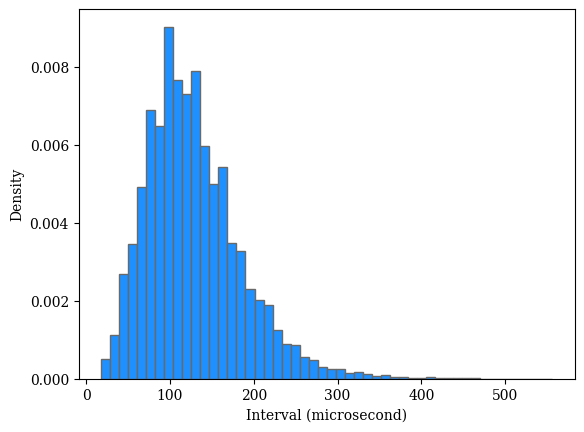

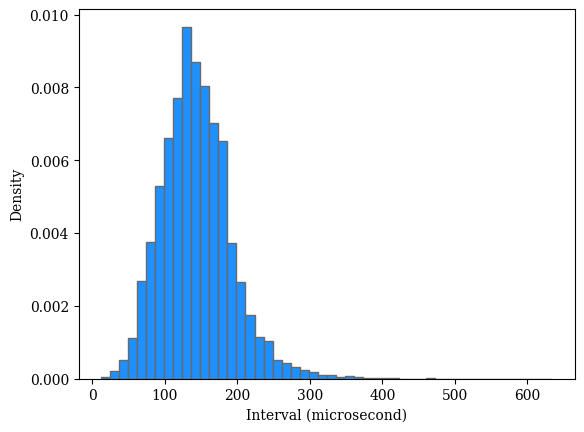

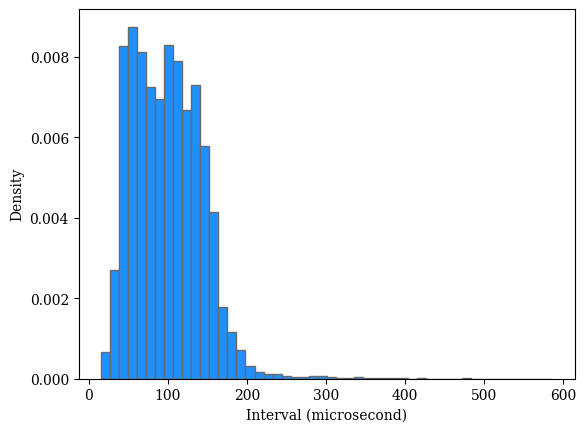

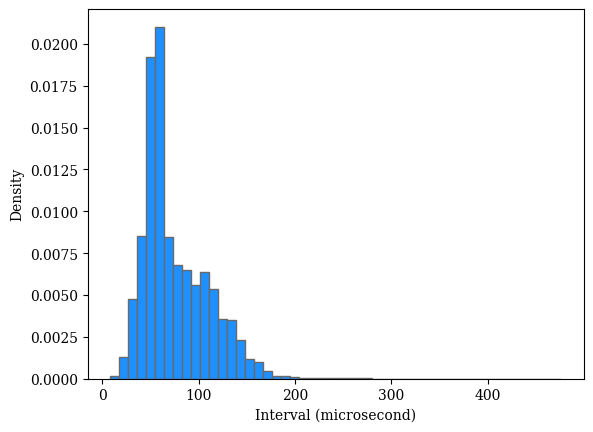

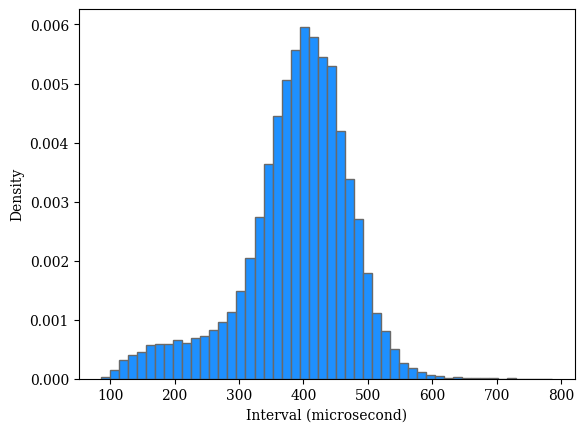

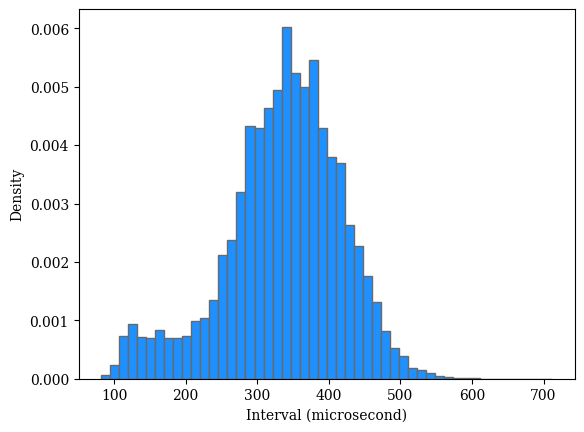

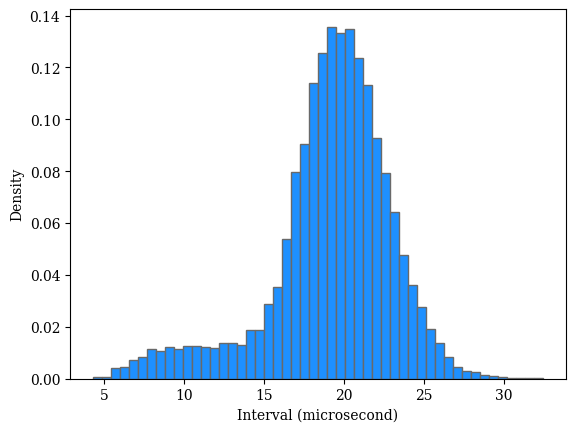

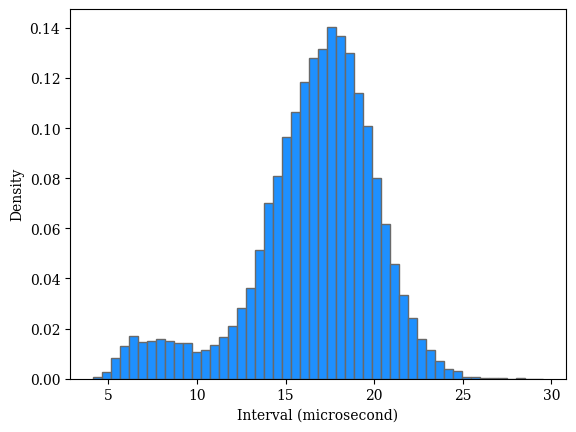

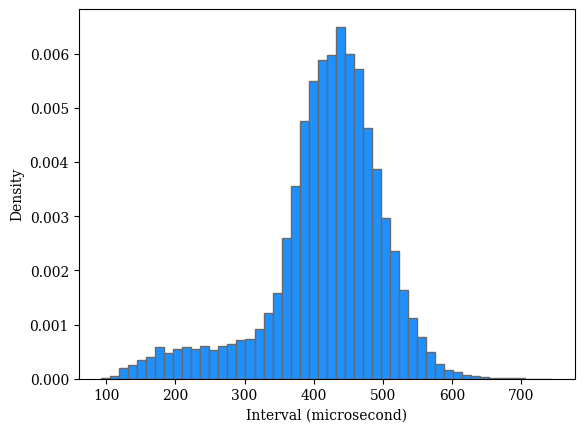

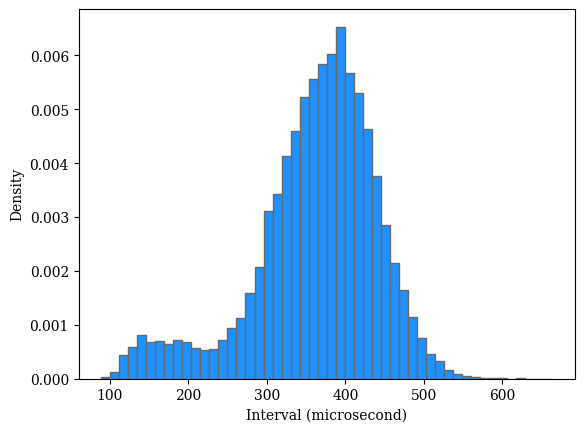

reconstructor_type='FastformerPlus', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=62.0
reference_skewness=1.0414486089304602, reconstructed_skewness=0.8400524292378079
reference_kurtosis=5.052903207896733, reconstructed_kurtosis=5.39324491706526


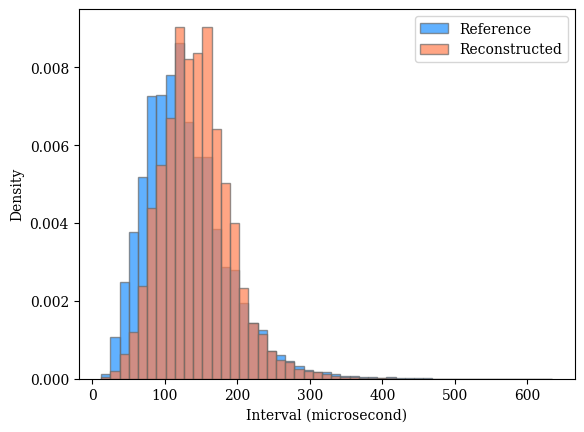

reconstructor_type='FastformerPlus', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=46.0
reference_skewness=1.0605115455602279, reconstructed_skewness=1.4490448974758974
reference_kurtosis=7.035118046944344, reconstructed_kurtosis=8.033582173394587


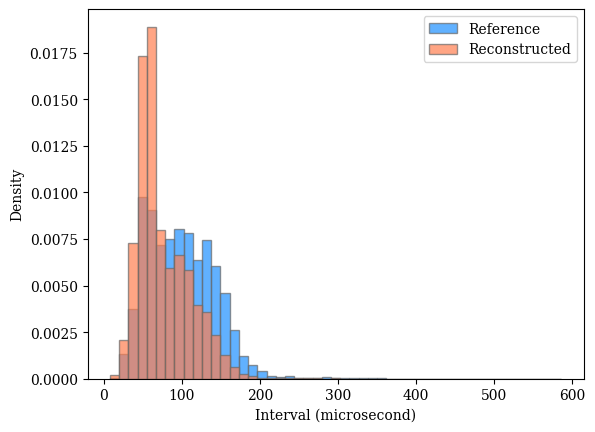

reconstructor_type='FastformerPlus', i='qt_label', j='qt_pred'
reference_iqr=94.0, reconstructed_iqr=98.0
reference_skewness=-0.8306868462647055, reconstructed_skewness=-0.5265304881335076
reference_kurtosis=4.109218801371053, reconstructed_kurtosis=3.402339075521262


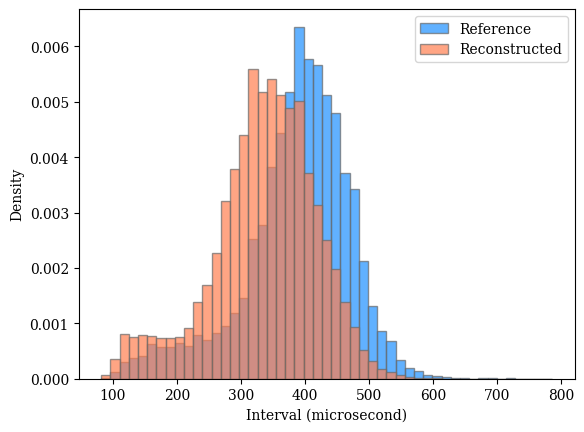

reconstructor_type='FastformerPlus', i='qtcb_label', j='qtcb_pred'
reference_iqr=4.000017220993488, reconstructed_iqr=4.0209659278605905
reference_skewness=-0.9541043376024435, reconstructed_skewness=-0.9007163153446088
reference_kurtosis=4.553329211408609, reconstructed_kurtosis=4.093484189378921


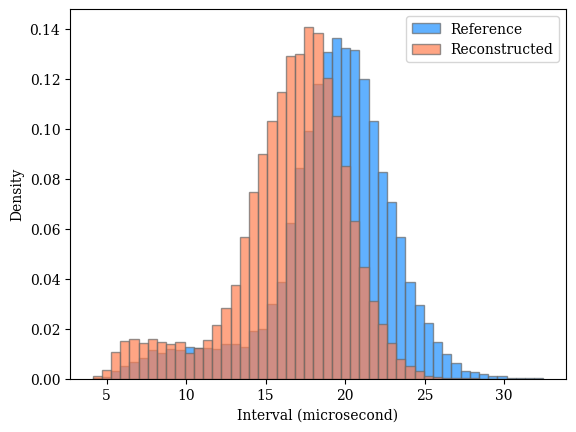

reconstructor_type='FastformerPlus', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.65516645869803, reconstructed_iqr=90.1448385170417
reference_skewness=-1.0170770899832404, reconstructed_skewness=-0.8717924976927341
reference_kurtosis=4.64537461135381, reconstructed_kurtosis=3.9943186028334594


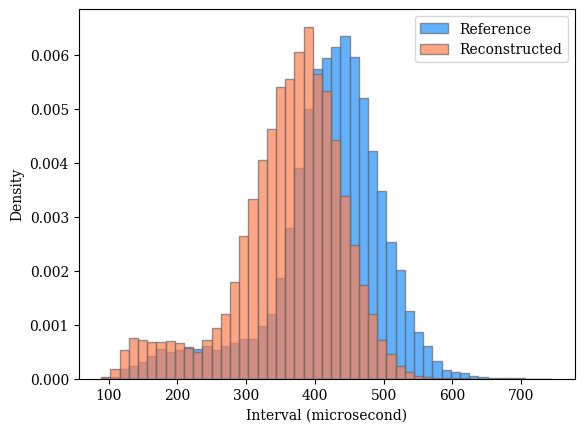


reconstructor_type='UFastformer'


  0%|          | 0/3265 [00:00<?, ?it/s]

Valid locations (higher is better): 29956
Valid locations (higher is better): 29956
Average difference (lower is better):
{'pr_diff': 0.6509885899136876, 'qrs_diff': 0.42469379182946343, 'qtcb_diff': 0.2067634848270491, 'qtcr_diff': 0.20676433004117553, 'rr_diff': 0.0008903471468866223, 'hr_diff': 0.0008896190167101441}
[9, 21, 31, 41, 46, 57, 66, 77, 84, 93, 100, 108, 119, 130, 130, 139, 150, 162, 173, 182, 189, 202, 204, 218, 220, 226, 234, 234, 240, 253, 265, 277, 288, 299, 306, 316, 320, 332, 341, 353, 358, 373, 383, 395, 407, 421, 430, 438, 452, 462, 469, 481, 490, 502, 513, 521, 531, 538, 549, 561, 570, 580, 591, 607, 618, 628, 631, 643, 655, 668, 684, 692, 700, 713, 727, 734, 745, 754, 767, 775, 783, 787, 795, 805, 816, 824, 831, 841, 856, 862, 863, 873, 880, 886, 893, 902, 914, 917, 933, 944, 952, 962, 965, 976, 988, 992, 998, 1008, 1015, 1019, 1027, 1040, 1051, 1062, 1070, 1079, 1093, 1093, 1105, 1115, 1125, 1132, 1139, 1148, 1158, 1164, 1174, 1186, 1196, 1204, 1204, 1215, 122

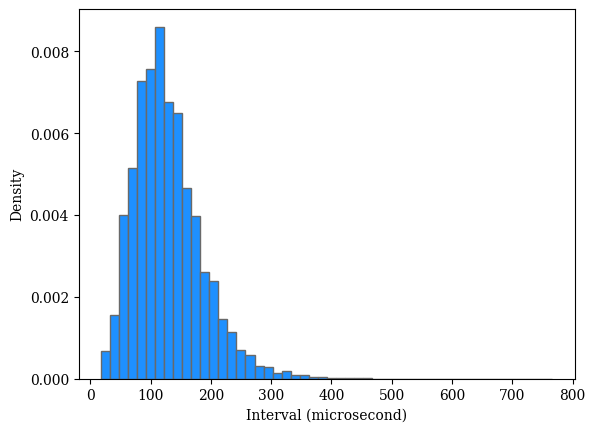

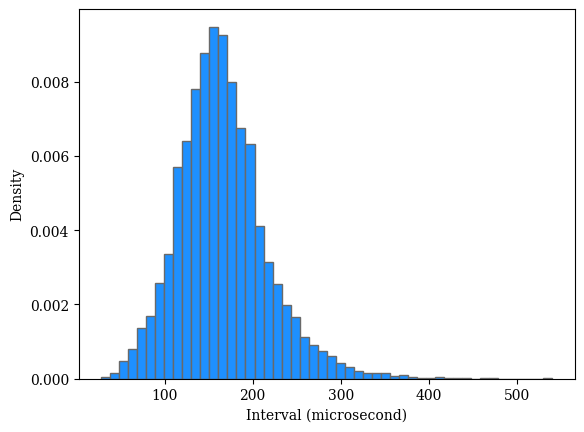

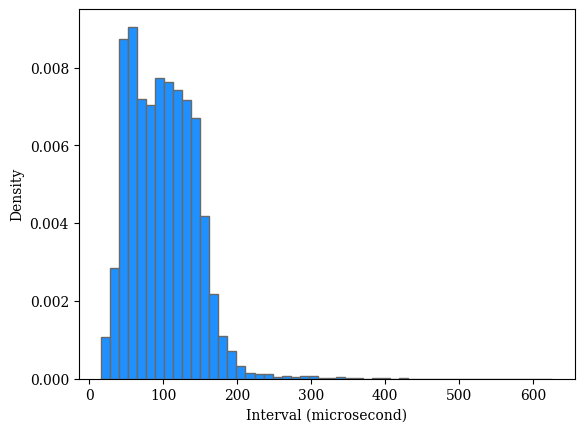

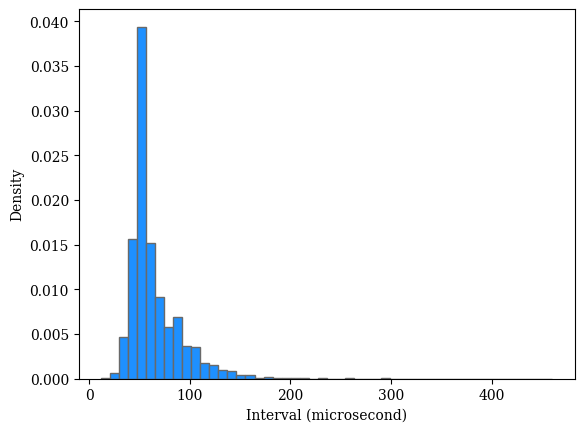

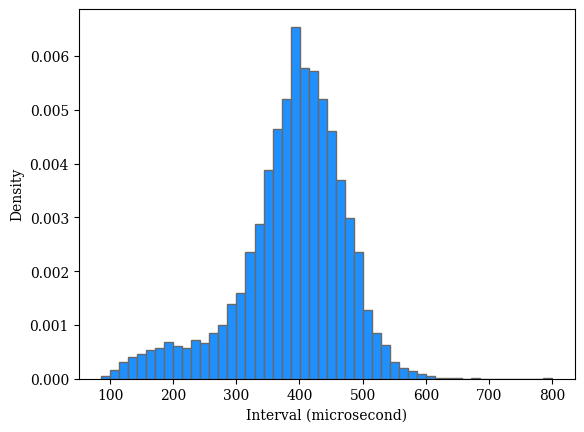

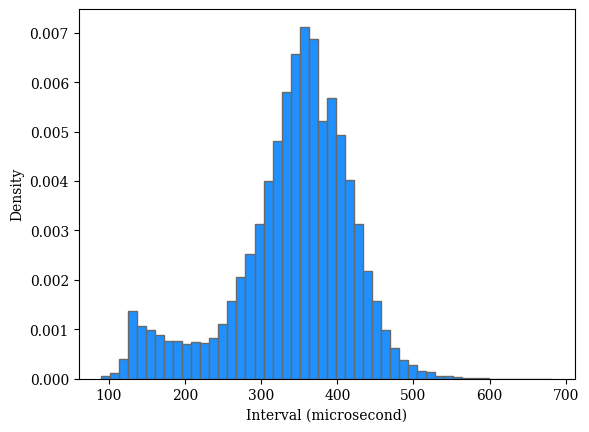

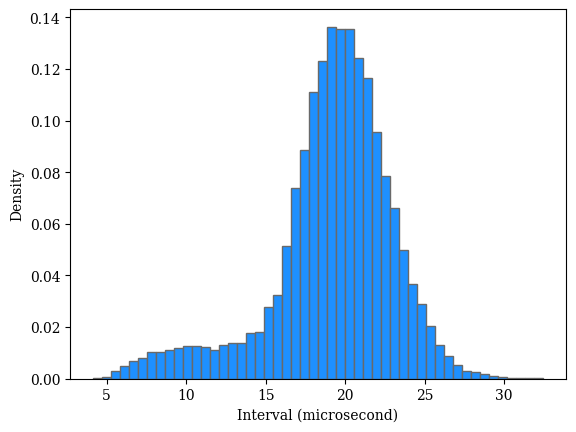

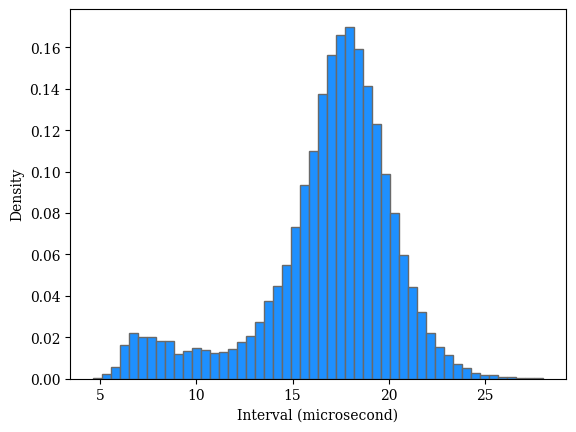

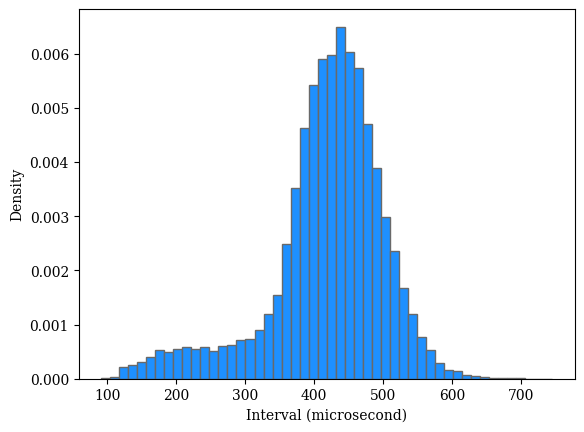

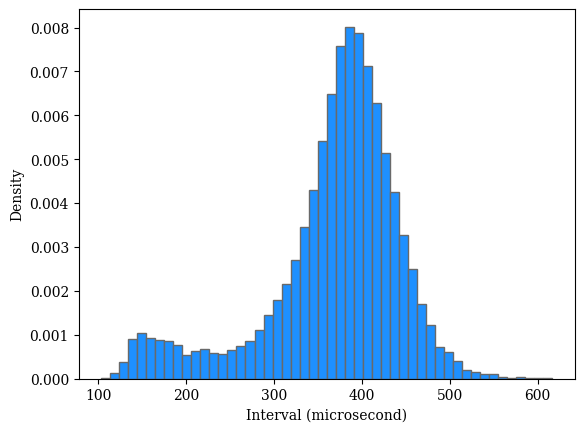

reconstructor_type='UFastformer', i='pr_label', j='pr_pred'
reference_iqr=70.0, reconstructed_iqr=58.0
reference_skewness=1.070832977231362, reconstructed_skewness=0.8960810910371412
reference_kurtosis=5.485735609226441, reconstructed_kurtosis=5.47796148757722


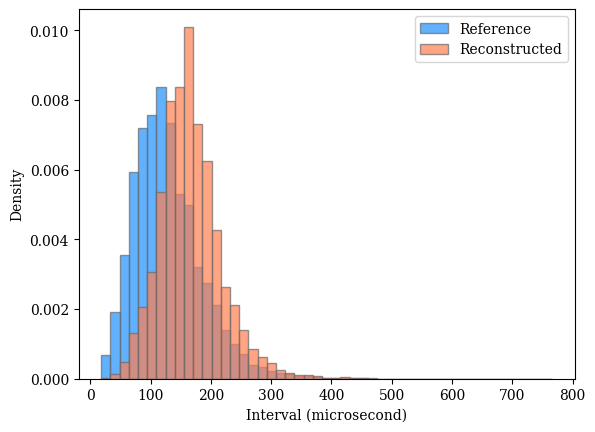

reconstructor_type='UFastformer', i='qrs_label', j='qrs_pred'
reference_iqr=66.0, reconstructed_iqr=24.0
reference_skewness=1.0064676851822951, reconstructed_skewness=3.4781731961800824
reference_kurtosis=6.604897762164648, reconstructed_kurtosis=27.625383099369838


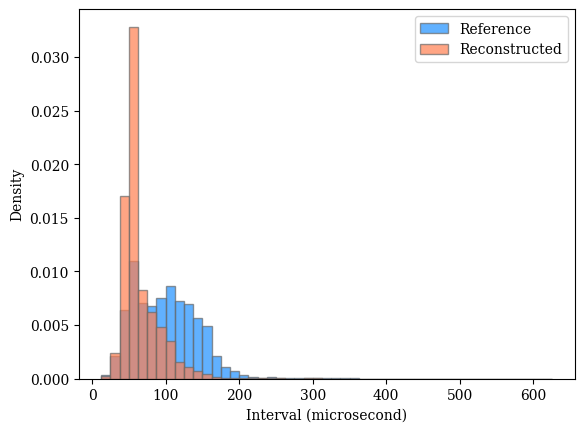

reconstructor_type='UFastformer', i='qt_label', j='qt_pred'
reference_iqr=92.0, reconstructed_iqr=84.0
reference_skewness=-0.830989963331077, reconstructed_skewness=-0.8444669028197254
reference_kurtosis=4.134053700079682, reconstructed_kurtosis=3.8042026396117987


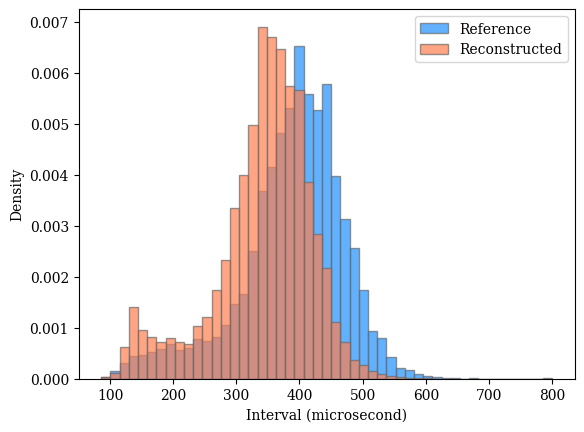

reconstructor_type='UFastformer', i='qtcb_label', j='qtcb_pred'
reference_iqr=3.9886379010930106, reconstructed_iqr=3.4344686034072147
reference_skewness=-0.9542435591274668, reconstructed_skewness=-1.0913010656689823
reference_kurtosis=4.572840448009838, reconstructed_kurtosis=4.405963554584637


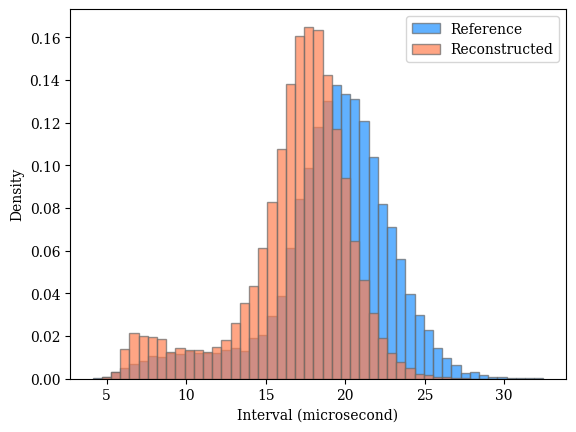

reconstructor_type='UFastformer', i='qtcr_label', j='qtcr_pred'
reference_iqr=85.44819792019689, reconstructed_iqr=74.21873838419026
reference_skewness=-1.015551850951635, reconstructed_skewness=-1.1197606223842378
reference_kurtosis=4.660843268910592, reconstructed_kurtosis=4.411830514876303


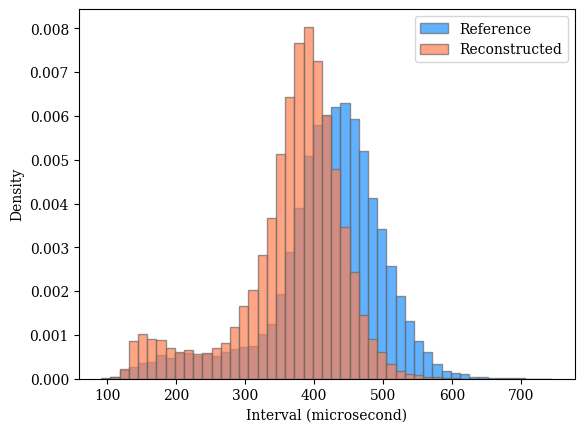